# Script to process PIV values 
## 
### ToDos: 
- [ ] Make a graph of velocity vs time
- [ ] Make a graph of velocity vs distance
- [ ] 

In [1]:
#Import required packages
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import re
from glob import glob
import skimage.io
import datetime
from scipy.ndimage import gaussian_filter
import pandas as pd
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy import stats
import math
from tqdm import tqdm

In [2]:
class flowProfilePIVAnalyzer:
    def __init__(self, folder_path, **kwargs): 
        self.folder_path = folder_path
        self.folder_name = os.path.basename(folder_path)
        #Input the pixel size and time interval as keyword arguments
        for key, value in kwargs.items():
            setattr(self, key, value)
    def _load_data(self, file_path):
        """Load data from a text file."""
        datafile=np.loadtxt(file_path, skiprows=3, delimiter=",")
        return datafile
    
    #function to calculate the average flow profile in y direction
    def _calculate_flow_profile(self, datafile):
        #Calculate the average flow profile in y direction
        y_flow_profile = np.mean(datafile[:,3], axis=0)
        return y_flow_profile

In [3]:
testfolder="H:/PHD_data/Imaging_et_analysis/NikSD/2023/01_Jan/17012023_K4K8MOYSL/TimeSrs002/Pos001/PIV/ASCII/"
testfile=glob(testfolder+"*.txt")
def get_data(file):
    datanp=np.loadtxt(file,skiprows=3,delimiter=",")
    x=datanp[:,0]
    y=datanp[:,1]
    u=datanp[:,2]
    v=datanp[:,3]
    magnitude=np.sqrt(u**2+v**2)
    direction=np.arctan2(v,u)
    return x,y,u,v,magnitude,direction

def get_central_point(x,y,u,v,magnitude,direction):
    # Define threshold angle (in radians)
    threshold_angle = np.deg2rad(10) 
    # Group vectors based on their direction
    groups = []
    for i in range(len(direction)):
        grouped = False
        for group in groups:
            if np.any(np.abs(group - direction[i]) < threshold_angle):
                group.append(direction[i])
                grouped = True
                break
        if not grouped:
            groups.append([direction[i]])
    # Calculate centroid for each group
    central_points = []
    for group in groups:
        group_indices = np.where(np.isin(direction, group))
        group_x = x[group_indices]
        group_y = y[group_indices]
        centroid = np.mean(group_x), np.mean(group_y)
        central_points.append(centroid)
    center_x=np.mean(x)
    center_y=np.mean(y)
    centerdist=np.sqrt(np.sum((central_points-np.array([center_x,center_y]))**2,axis=1))
    closest_index=np.argmin(centerdist)
    xcenter,ycenter=central_points[closest_index]
    return xcenter,ycenter

def plot_quiver(folder,x,y,u,v,magnitude,direction,show=True):
    fig, ax = plt.subplots()
    ax.quiver(x,y,u,v,magnitude)
    # Calculate weighted average of vector endpoints
    central_x, central_y = get_central_point(x,y,u,v,magnitude,direction)
    plt.scatter(central_x, central_y, color='r')
    os.makedirs(folder+"/QuiverRes/",exist_ok=True)
    plt.savefig(folder+f'/QuiverRes/quiver_{np.nanmean(magnitude)}.png')
    if show:
        plt.show()
    else:
        plt.close()
def plot_spatialaverage(folder,x,y,u,v,magnitude,direction,show=True):
    fig,ax=plt.subplots()
    mean_magnitudes=np.zeros(len(np.unique(y)))
    mean_magnitudes_std=np.zeros(len(np.unique(y)))
    mean_vmag=np.zeros(len(np.unique(y)))
    mean_vmag_std=np.zeros(len(np.unique(y)))
    for i,yval in enumerate(np.unique(y)):
        indices=np.where(y==yval)
        mean_magnitudes[i]=np.nanmean(magnitude[indices])
        mean_vmag[i]=np.nanmean(v[indices])
        mean_magnitudes_std[i]=np.nanstd(magnitude[indices])
        mean_vmag_std[i]=np.nanstd(v[indices])

    #plt.plot(np.unique(y),mean_magnitudes,color="#FF0000",linewidth=2)
    #plt.fill_between(np.unique(y),np.array(mean_magnitudes)-np.array(mean_magnitudes_std),np.array(mean_magnitudes)+np.array(mean_magnitudes_std),color="#FF0000",alpha=0.5)
    plt.plot(np.unique(y),mean_vmag,color="#83bb03")
    plt.fill_between(np.unique(y),mean_vmag-mean_vmag_std,mean_vmag+mean_vmag_std,color="#83bb03",alpha=0.5)
    if show:
        plt.show()
    else:
        plt.close()
    return(mean_vmag,mean_vmag_std)
vmagdict={}
for i in tqdm(range(len(testfile))):
    name=os.path.basename(testfile[i])[:-4]
    x,y,u,v,magnitude,direction=get_data(testfile[i])
    #plot_quiver(testfolder,x,y,u,v,magnitude,direction)
    vmagdict[name]=plot_spatialaverage(testfolder,x,y,u,v,magnitude,direction,show=False)


100%|██████████| 8/8 [00:00<00:00, 12.24it/s]


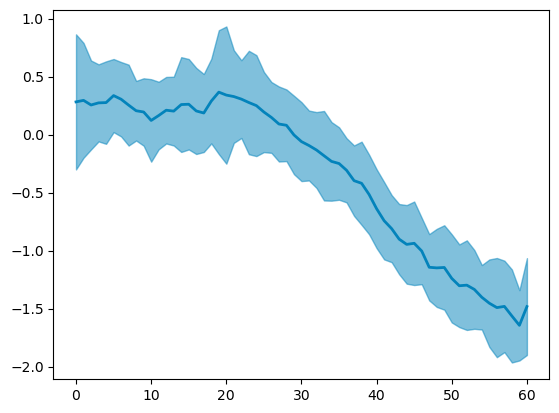

In [7]:
plt.plot(vmagdict["PIVlab_0001"][0],color="#0383bb",linewidth=2)
plt.fill_between(np.arange(len(vmagdict["PIVlab_0001"][0])),vmagdict["PIVlab_0001"][0]-vmagdict["PIVlab_0001"][1],vmagdict["PIVlab_0001"][0]+vmagdict["PIVlab_0001"][1],color="#0383bb",alpha=0.5)

In [8]:
Control1folder="H:/PHD_data/Imaging_et_analysis/NikSD/2023/01_Jan/17012023_K4K8MOYSL/TimeSrs002/Pos001/PIV/ASCII/"
YSLMOfolder="H:/PHD_data/Imaging_et_analysis/NikSD/2023/01_Jan/17012023_K4K8MOYSL/TimeSrs002/Pos002/PIV/ASCII/"
Controlfolder2="H:/PHD_data/Imaging_et_analysis/NikSD/2023/01_Jan/17012023_K4K8MOYSL/TimeSrs003/Pos001/PIV/ASCII/"
Controlfolder3="H:/PHD_data/Imaging_et_analysis/NikSD/2023/01_Jan/17012023_K4K8MOYSL/TimeSrs003/Pos001/PIV/ASCII_F2/"
Controlfolder4="H:/PHD_data/Imaging_et_analysis/NikSD/2023/01_Jan/17012023_K4K8MOYSL/TimeSrs003/Pos001/PIV/ASCII_F3/"
YSLMOfolder2="H:/PHD_data/Imaging_et_analysis/NikSD/2023/01_Jan/17012023_K4K8MOYSL/TimeSrs003/Pos002/PIV/ASCII/"
YSLMOfolder3="H:/PHD_data/Imaging_et_analysis/NikSD/2023/01_Jan/17012023_K4K8MOYSL/TimeSrs003/Pos002/PIV/ASCII_F2/"
controlmagdict1={}
controlmagdict2={}
controlmagdict3={}
controlmagdict4={}
yslmomagdict1={}
yslmomagdict2={}
yslmomagdict3={}
folders=[Control1folder,YSLMOfolder,Controlfolder2,Controlfolder3,Controlfolder4,YSLMOfolder2,YSLMOfolder3]
for folder in tqdm(folders):
    testfile=glob(folder+"*.txt")
    vmagdict={}
    for i in range(len(testfile)):
        name=os.path.basename(testfile[i])[:-4]
        x,y,u,v,magnitude,direction=get_data(testfile[i])
        #plot_quiver(testfolder,x,y,u,v,magnitude,direction)
        vmagdict[name]=plot_spatialaverage(folder,x,y,u,v,magnitude,direction,show=False)
    if folder==Control1folder:
        controlmagdict1=vmagdict
    elif folder==YSLMOfolder:
        yslmomagdict1=vmagdict
    elif folder==Controlfolder2:
        controlmagdict2=vmagdict
    elif folder==Controlfolder3:
        controlmagdict3=vmagdict
    elif folder==Controlfolder4:
        controlmagdict4=vmagdict
    elif folder==YSLMOfolder2:
        yslmomagdict2=vmagdict
    elif folder==YSLMOfolder3:
        yslmomagdict3=vmagdict

 29%|██▊       | 2/7 [00:01<00:02,  1.72it/s]C:\Users\snaik\AppData\Local\Temp\ipykernel_8728\2201746959.py:62: RuntimeWarning: Mean of empty slice
  mean_magnitudes[i]=np.nanmean(magnitude[indices])
C:\Users\snaik\AppData\Local\Temp\ipykernel_8728\2201746959.py:63: RuntimeWarning: Mean of empty slice
  mean_vmag[i]=np.nanmean(v[indices])
c:\miniforge3\envs\snBase\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


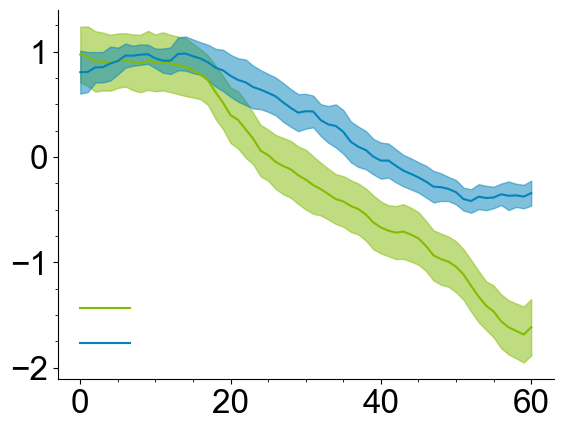

In [12]:
def plot_magdict(magdict):
    for key in magdict.keys():
        plt.plot(magdict[key][0],label=key)
        plt.fill_between(np.arange(len(magdict[key][0])),magdict[key][0]-magdict[key][1],magdict[key][0]+magdict[key][1],alpha=0.5)
def plot_averagemagdict(magdict,dictname:str):
    mean_magdict={}
    for key in magdict.keys():
        mean_magdict[key]=magdict[key][0]
    df=pd.DataFrame(mean_magdict)
    dfmean=df.mean(axis=1)
    dfstd=df.sem(axis=1)
    if dictname=="    ":
        colorname="#83bb03"
    else:
        colorname="#0383bb"
    plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
    plt.rcParams['font.size'] = 24
    plt.rcParams['savefig.dpi'] = 300
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = 'Arial'
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['top'].set_color('none')
    #plt.ylabel("Flow velocity(µm/s)")
    plt.plot(dfmean,color=colorname,label=dictname)
    plt.fill_between(dfmean.index,dfmean-dfstd,dfmean+dfstd,alpha=0.5,color=colorname)
    plt.gca().invert_yaxis()
#function to take the average of the magnitude dictionaries and plot control vs ysl mo
controldict={**controlmagdict1, **controlmagdict2, **controlmagdict3, **controlmagdict4}
ysldict={**yslmomagdict1,**yslmomagdict2,**yslmomagdict3}

plot_averagemagdict(controldict,"    ")
plot_averagemagdict(ysldict,"       ")
plt.legend(loc="lower left",frameon=False,fontsize=18)
plt.xticks(np.arange(0,60,5),minor=True)
plt.yticks(np.arange(-2,1.5,0.25),minor=True)

plt.savefig("H:/PHD_data/Imaging_et_analysis/PaperFigures/Figure5/YSLFlowVel/Flowprofile_nolab.png",dpi=300,transparent=True,bbox_inches='tight')
plt.savefig("H:/PHD_data/Imaging_et_analysis/PaperFigures/Figure5/YSLFlowVel/Flowprofile_nolab.svg",dpi=300,transparent=True,bbox_inches='tight')
plt.savefig("H:/PHD_data/Imaging_et_analysis/PaperFigures/Figure5/YSLFlowVel/Flowprofile_nolab.pdf",dpi=300,transparent=True,bbox_inches='tight')
#plt.show()

In [ ]:
for file in glob(Controlfolder4+"/*.txt"):
    x,y,u,v,magnitude,direction=get_data(file)
    plot_quiver(Controlfolder4,x,y,u,v,magnitude,direction)

In [ ]:
x,y,u,v,magnitude,direction=get_data(testfile[0])
mag_mean=np.zeros(len(np.unique(y)))
v_mean=np.zeros(len(np.unique(y)))
for i,yval in tqdm(enumerate(np.unique(y))):
    indices=np.where(y==yval)
    mag_mean[i]=np.nanmean(magnitude[indices])
    v_mean[i]=np.nanmean(v[indices])
plt.plot(np.unique(y),mag_mean)
plt.plot(np.unique(y),v_mean,color="green")
    

In [ ]:
pixel_size = float(input("Please enter the pixel size: "))
time_interval=float(input("Please enter the time interval: "))

In [6]:
# Basic functions needed to process the data

# Function to create a folder

def create_folder(path):
    isExist = os.path.exists(path) 
    if not isExist:
        os.makedirs(path)

#Defining a function to process the PIV files and make a dataframe with the data
class CutPyto:
    def __init__(self,folderpath, pixel_size, time_interval) -> None:
        self.folderpath = folderpath
        self.pixel_size = pixel_size
        self.time_interval = time_interval
        self.ascifiles=glob(folderpath+"/*.txt")
        self.ascifiles.sort()   
        self.noframes=len(self.ascifiles)
        self.segthresh=0.8
        self.dataframe=pd.DataFrame()
    
    def PIVprocess(self):
        x2=[[]]*self.noframes
        y2=[[]]*self.noframes
        u2=[[]]*self.noframes
        v2=[[]]*self.noframes    
        for i in range(self.noframes):
            df=pd.read_csv(self.ascifiles[i], sep='\t', header=1)
            x2[i]=np.array(df['x [px]'])
            y2[i]=np.array(df['y [px]'])
            u2[i]=np.array(df['u [px/frame]'])*self.pixel_size / self.time_interval
            v2[i]=np.array(df['v [px/frame]'])*self.pixel_size / self.time_interval
        x3=sorted(list(set(x2[0])))
        y3=sorted(list(set(y2[0])))
        x = x2[0].reshape(len(x3), len(y3))
        y = y2[0].reshape(len(x3), len(y3))
        u = u2.reshape(frame_num, len(x3), len(y3))
        v = v2.reshape(frame_num, len(x3), len(y3))
        vel=np.sqrt(u**2+v**2)
        vel2=np.nan_to_num(vel)
        class Piv_data_rearranged:
            def __init__(self, t_interval, frame_num, x, y, u, v, vel, x2, y2, u2, v2, vel2, x3, y3):
                self.t = np.arange(frame_num-1) * t_interval
                self.f = frame_num
                self.x, self.y, self.u, self.v = x,y,u,v
                self.x2, self.y2, self.u2, self.v2 = x2,y2,u2,v2
                self.x3, self.y3 = x3, y3
                self.vel, self.vel2 = vel, vel2                                 
        self.dataframe=self.dataframe.append(pd.DataFrame(Piv_data_rearranged(self.time_interval, self.noframes, x, y, u, v, vel, xidx, yidx, u, v, vel2, x, y)))
        return self.dataframe

    def evl_ysl_boundary_analysis(self,kymo,self.pixel_size,self.time_interval,self.segthresh):
        frames,height=kymo.shape
        #boundary segmentation
        ysl_boundary=np.empty(frames)
        for f in range(frames):
            

SyntaxError: invalid syntax (3577779264.py, line 52)

In [ ]:
file="H:\\PHD_data\\Imaging_et_analysis\\NikSD\\2023\\01_Jan\\24012023_K4K8MOonecell\\Flows_timeseries01\\Control\\TimeSeries00\\"
files=glob(file+"*.txt")
numfiles=len(files)
data=pd.read_csv(files[0], sep=',', skiprows=1, header=1)
x2=[[]]*numfiles
y2=[[]]*numfiles
u2=[[]]*numfiles
v2=[[]]*numfiles

for i in range(numfiles):
    data=pd.read_csv(files[i], sep=',', skiprows=1, header=1)
    x2[i]=np.array(data['x [px]'])
    y2[i]=np.array(data['y [px]'])
    u2[i]=np.array(data['u [px/frame]'])*pixelsizepixel_size/time_interval
    v2[i]=np.array(data['v [px/frame]'])*pixelsizepixel_size/time_interval
x3=sorted(list(set(data['x [px]'])))
y3=sorted(list(set(data['y [px]'])))


print(f"Set of {data['x [px]']} is {list(set(data['x [px]']))}")


In [7]:
#Alignement test
testfile1="H:/PHD_data/Imaging_et_analysis/NikSD/2023/01_Jan/17012023_K4K8MOYSL/TimeSrs005/Pos001/PIV/ASCII/PIVlab_0001.txt"
testmofile1="H:/PHD_data/Imaging_et_analysis/NikSD/2023/01_Jan/17012023_K4K8MOYSL/TimeSrs005/Pos002/PIV/ASCII/PIVlab_0002.txt"
data=pd.read_csv(testfile1, sep=',', skiprows=1, header=1)
modata=pd.read_csv(testmofile1, sep=',', skiprows=1, header=1)
# Calculate direction in degrees
data['direction'] = np.degrees(np.arctan2(data['v [px/frame]'], data['u [px/frame]']))
data['dire1'] = np.degrees(np.arctan2(data['v [px/frame]']*0.325/30, data['u [px/frame]']*0.325/30))
modata['direction'] = np.degrees(np.arctan2(modata['v [px/frame]'], modata['u [px/frame]']))
modata['dire1'] = np.degrees(np.arctan2(modata['v [px/frame]']*0.325/30, modata['u [px/frame]']*0.325/30))
modata.head(20)

,x [px],y [px],u [px/frame],v [px/frame],Vector type [-],direction,dire1
0,18,18,0.797598,1.705846,1,64.940742,64.940742
1,18,34,0.982601,0.358430,1,20.040795,20.040795
2,18,50,1.194765,0.064824,1,3.105630,3.105630
3,18,66,1.309549,-0.684603,1,-27.599560,-27.599560
4,18,82,2.121670,-1.107036,1,-27.554446,-27.554446
5,18,98,1.529101,-0.178711,1,-6.666103,-6.666103
6,18,114,1.492635,0.055331,1,2.122929,2.122929
7,18,130,1.797620,0.176665,1,5.612849,5.612849
8,18,146,1.413122,0.181869,1,7.333664,7.333664
9,18,162,1.208687,0.346969,1,16.016778,16.016778


In [8]:
from sklearn.decomposition import PCA
datanona=data.dropna()
vector_data =np.column_stack( (datanona['u [px/frame]'], datanona['v [px/frame]']))
# Perform PCA
pca = PCA(n_components=1)
pca.fit(vector_data)
# Principal component direction
principal_direction = pca.components_[0]
principal_direction

array([-0.23041274,  0.97309299])

In [9]:
from scipy.stats import circmean, circvar

modatanona=modata.dropna()

# Convert directions to radians
directions_radians = np.deg2rad(datanona['direction'].values)
modirections_radians = np.deg2rad(modatanona['direction'].values)
# Calculate circular mean
circular_mean = circmean(directions_radians)
circular_meanMO = circmean(modirections_radians)
# Calculate circular variance
circular_variance = circvar(directions_radians)
circular_varianceMO = circvar(modirections_radians)
circular_mean, circular_variance,circular_meanMO,circular_varianceMO

(0.21993421181025768,
 0.5268175034493353,
 0.05358936381772997,
 0.07590100955993306)

In [10]:
# ALignemnet complie for YSL MO and control 

controlfolder1="H:/PHD_data/Imaging_et_analysis/NikSD/2023/01_Jan/17012023_K4K8MOYSL/TimeSrs005/Pos001/PIV/ASCII/"
yslmofolder1="H:/PHD_data/Imaging_et_analysis/NikSD/2023/01_Jan/17012023_K4K8MOYSL/TimeSrs005/Pos002/PIV/ASCII/"
controlfolder2="H:/PHD_data/Imaging_et_analysis/NikSD/2023/03_Mar/07032023/20230307_175703_803/TimeSrs0000/Pos0000/PIV/ASCII/"
yslmofolder2="H:/PHD_data/Imaging_et_analysis/NikSD/2023/03_Mar/07032023/20230307_175703_803/TimeSrs0000/Pos0001/PIV/ASCII/"
controlfolder3="H:/PHD_data/Imaging_et_analysis/NikSD/2023/03_Mar/21032023/20230321_170413_923/TimeSrs0001/Pos0001/PIV/ASCII/"
yslmofolder3="H:/PHD_data/Imaging_et_analysis/NikSD/2023/03_Mar/21032023/20230321_170413_923/TimeSrs0001/Pos0002/PIV/ASCII/"
controlfolder4="H:/PHD_data/Imaging_et_analysis/NikSD/2023/07_Jul/06072023_K4K8YSLMO/20230706_175142_401/TimeSrs0000/Pos001/PIV/ASCII/"
yslmofolder4="H:/PHD_data/Imaging_et_analysis/NikSD/2023/07_Jul/06072023_K4K8YSLMO/20230706_175142_401/TimeSrs0000/Pos002/PIV/ASCII/"

In [11]:
for file in tqdm(glob(controlfolder1+"/*.txt")):
    data=pd.read_csv(file, sep=',', skiprows=1, header=1)
    # Calculate direction in degrees
    data['direction'] = np.degrees(np.arctan2(data['v [px/frame]'], data['u [px/frame]']))
    data=data.dropna()
    # Convert directions to radians
    directions_radians = np.deg2rad(data['direction'].values)
    # Calculate circular mean
    circular_mean = circmean(directions_radians)
    # Calculate circular variance
    circular_variance = circvar(directions_radians)
    print(f"Control 1: Circular mean: {circular_mean}, Circular variance: {circular_variance}")

 44%|████▍     | 4/9 [00:00<00:00, 31.69it/s]

Control 1: Circular mean: 0.21993421181025768, Circular variance: 0.5268175034493353
Control 1: Circular mean: 5.4246849137606885, Circular variance: 0.23084838498003002
Control 1: Circular mean: 5.592904603359051, Circular variance: 0.5435819825011892
Control 1: Circular mean: 5.329023566202893, Circular variance: 0.18299852149417029
Control 1: Circular mean: 6.0849654100705814, Circular variance: 0.2258761043541111
Control 1: Circular mean: 2.0627252870326003, Circular variance: 0.5212976719968294


100%|██████████| 9/9 [00:00<00:00, 25.36it/s]

Control 1: Circular mean: 5.142069339724929, Circular variance: 0.19709302264779882
Control 1: Circular mean: 4.935253112735178, Circular variance: 0.7049911187636303
Control 1: Circular mean: 4.851255314902506, Circular variance: 0.8008601580779761


In [12]:
def directionmak(folder,dict):
    testfile=glob(folder+"*.txt")
    for file in tqdm(testfile):
        data=pd.read_csv(file, sep=',', skiprows=1, header=1)
        data=data.dropna()
        data['direction'] = np.arctan2(data['v [px/frame]'], data['u [px/frame]'])
        dict[os.path.basename(file)]=circmean(data['direction'].values)
    return dict
cntdict1=directionmak(controlfolder1,{})
ysldict1=directionmak(yslmofolder1,{})
cntdict2=directionmak(controlfolder2,{})
ysldict2=directionmak(yslmofolder2,{})
cntdict3=directionmak(controlfolder3,{})
ysldict3=directionmak(yslmofolder3,{})
cntdict4=directionmak(controlfolder4,{})
ysldict4=directionmak(yslmofolder4,{})

100%|██████████| 19/19 [00:00<00:00, 26.22it/s]
0it [00:00, ?it/s]
100%|██████████| 24/24 [00:01<00:00, 15.92it/s]


In [13]:
# Specify the file path
file_path = 'C:/Users/snaik/Desktop/variables.txt'

# Open the file in write mode
with open(file_path, 'w') as file:
    # Write the variable values into the file
    file.write(f"Name: cntdict1\nType: {type(cntdict1)}\nValue: {cntdict1}\n\n")
    file.write(f"Name: ysldict1\nType: {type(ysldict1)}\nValue: {ysldict1}\n\n")
    file.write(f"Name: cntdict2\nType: {type(cntdict2)}\nValue: {cntdict2}\n\n")
    file.write(f"Name: ysldict2\nType: {type(ysldict2)}\nValue: {ysldict2}\n\n")
    file.write(f"Name: cntdict3\nType: {type(cntdict3)}\nValue: {cntdict3}\n\n")
    file.write(f"Name: ysldict3\nType: {type(ysldict3)}\nValue: {ysldict3}\n\n")
    file.write(f"Name: cntdict4\nType: {type(cntdict4)}\nValue: {cntdict4}\n\n")
    file.write(f"Name: ysldict4\nType: {type(ysldict4)}\nValue: {ysldict4}\n\n")

# Print a message to confirm that the file has been created
print(f"Variables have been printed to {file_path}")


Variables have been printed to C:/Users/snaik/Desktop/variables.txt


In [14]:
pd.concat([pd.DataFrame.from_dict(cntdict1,orient='index'),pd.DataFrame.from_dict(ysldict1,orient='index'),pd.DataFrame.from_dict(cntdict2,orient='index'),pd.DataFrame.from_dict(ysldict2,orient='index'),pd.DataFrame.from_dict(cntdict3,orient='index'),pd.DataFrame.from_dict(ysldict3,orient='index'),pd.DataFrame.from_dict(cntdict4,orient='index'),pd.DataFrame.from_dict(ysldict4,orient='index')],axis=1).to_csv("C:/Users/snaik/Desktop/Direction.csv")

In [ ]:
# Plotting the YSL alignment plotted from data compiled eariler a sns boxplot
import seaborn as sns
aligncompdata=pd.read_excel("C:/Users/snaik/Desktop/Flowalignment.xlsx")
#plot the figure!
fig, ax = plt.subplots(figsize=(7, 5.3), sharey=True)
 # Set the plot configurations
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 24
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
ax.set_yticks(np.arange(0,6.2,0.5),minor=True)
#colorpalette
colpal=["#83bb03", "#ff7f0e"]
sns.boxplot(data=aligncompdata, palette=colpal,width=0.3, boxprops=dict(alpha=.5))
#plt.ylabel("Flow alignment (rad)")
savefolder="H:/PHD_data/Imaging_et_analysis/PaperFigures/Figure5/YSLalignment/"
ax.set_xticklabels(["", ""])
aligncompdata.to_csv(savefolder+"YSLalignment.csv")
plt.savefig(savefolder+"YSLalignment_nolab.png",dpi=300,transparent=True,bbox_inches='tight')
plt.savefig(savefolder+"YSLalignment_nolab.svg",dpi=300,transparent=True,bbox_inches='tight')
plt.savefig(savefolder+"YSLalignment_nolab.pdf",dpi=300,transparent=True,bbox_inches='tight')
plt.show()


In [ ]:

cntdict1.values()

In [ ]:
circmean=[]
circmean2=[]
for x in circmeanvarcnt2.values():
    circmean.append(x[0])

for x in circmeanvarysl2.values():
    circmean2.append(x[0])
np.mean(circmean),np.mean(circmean2)

0it [00:00, ?it/s]

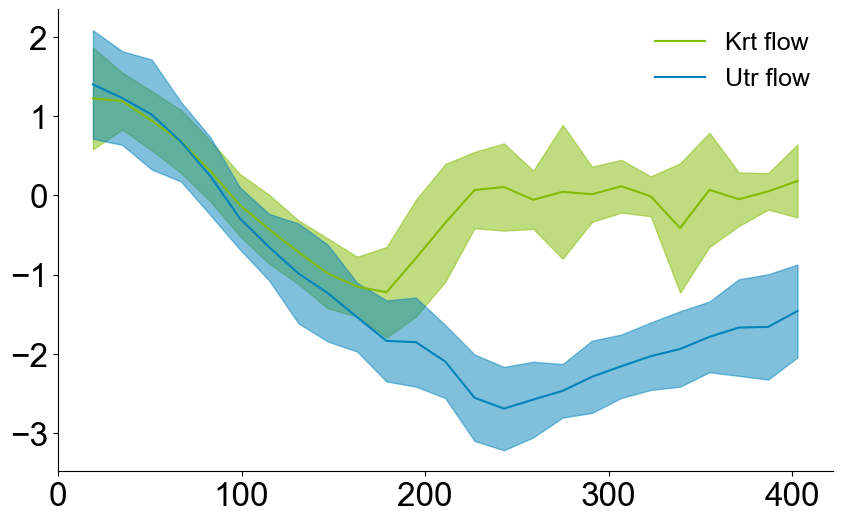

1it [00:00,  3.80it/s]

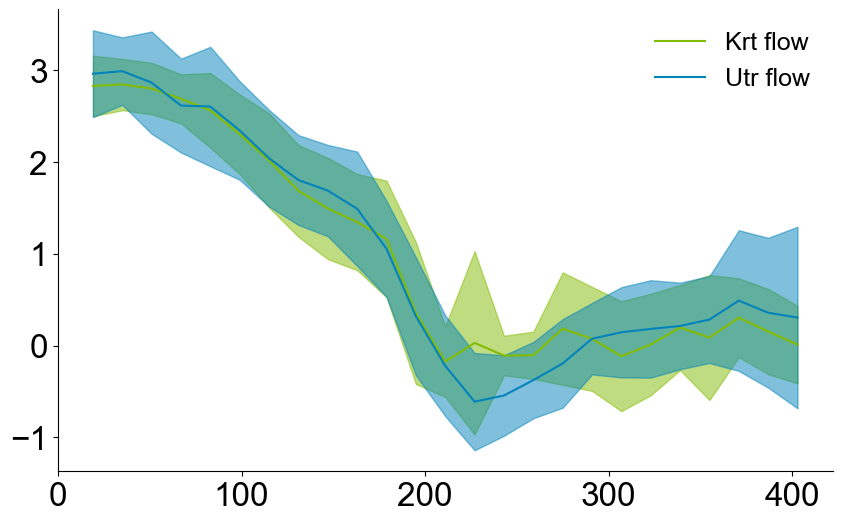

2it [00:00,  4.09it/s]

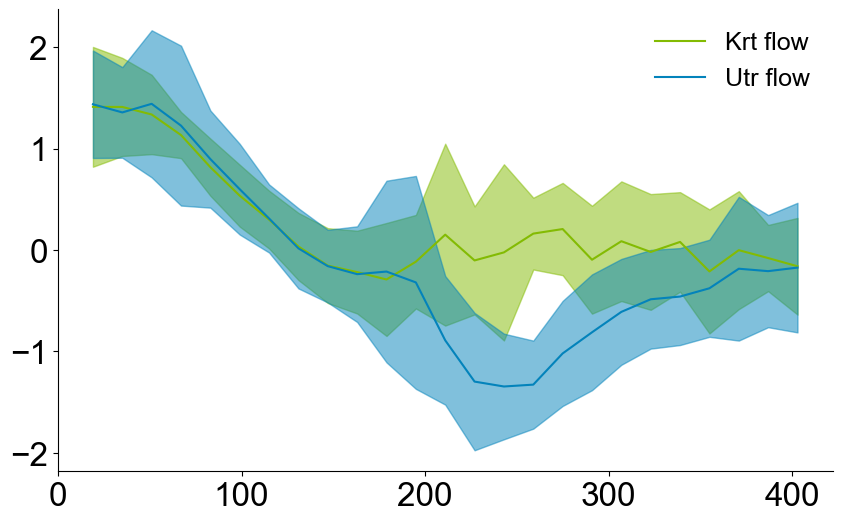

3it [00:00,  4.26it/s]

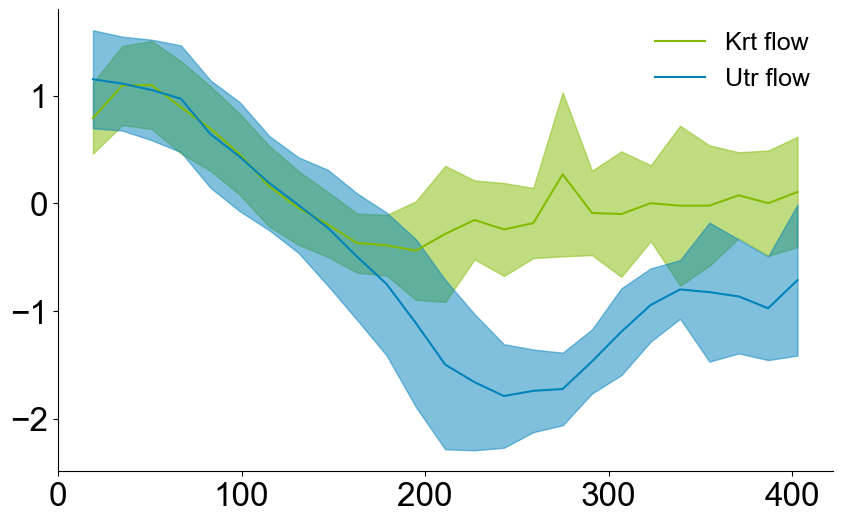

4it [00:00,  4.41it/s]

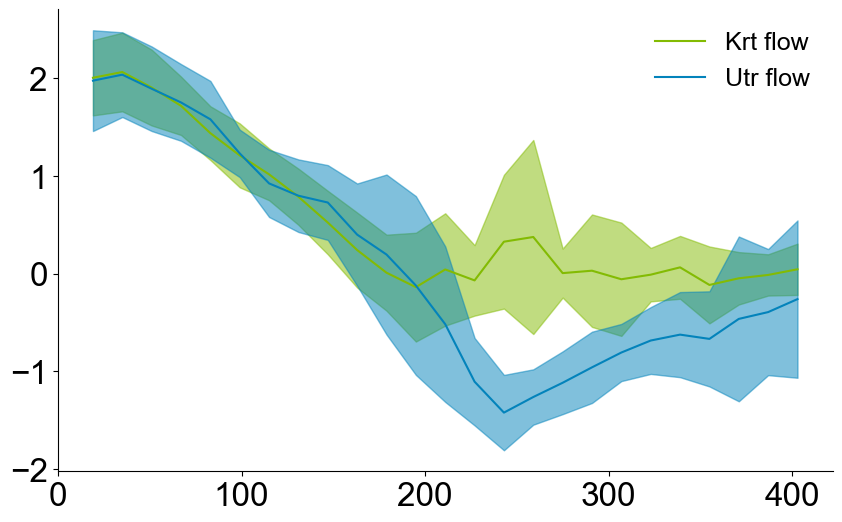

5it [00:01,  4.83it/s]

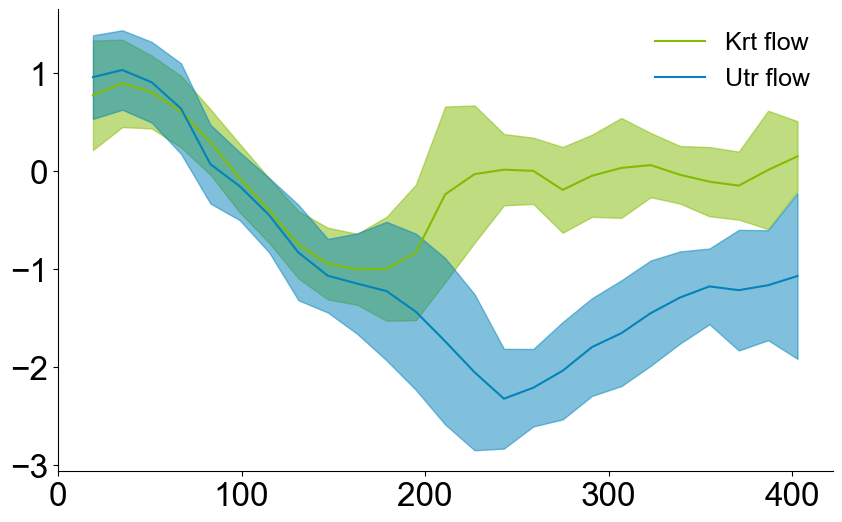

6it [00:01,  4.85it/s]

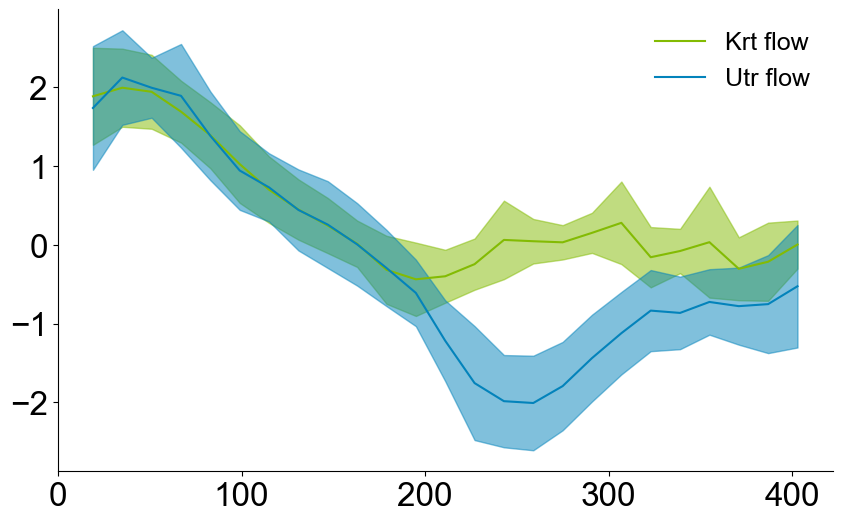

7it [00:01,  5.10it/s]

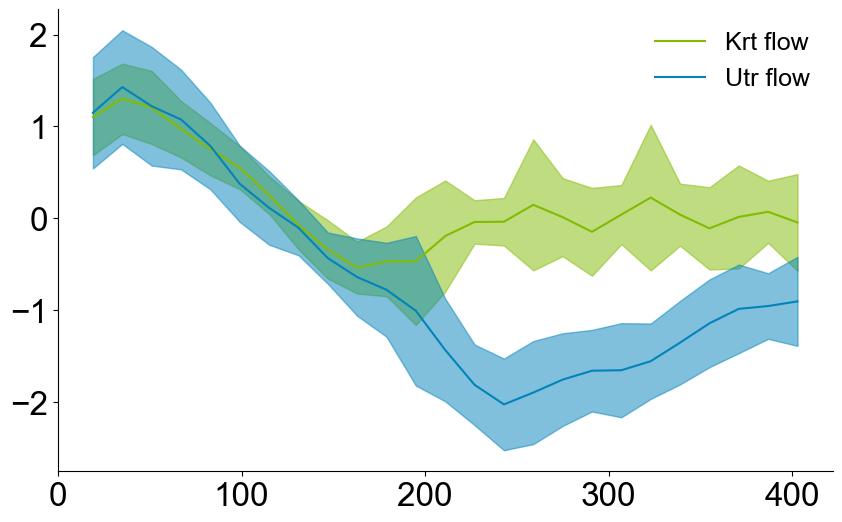

8it [00:01,  5.21it/s]

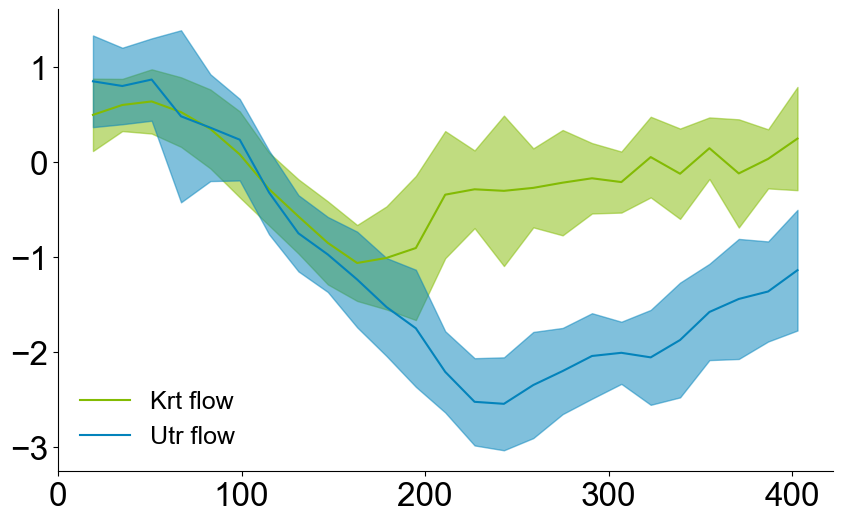

9it [00:01,  4.68it/s]


In [13]:
# Krt flows correlation
#folderkrt1="H:/PHD_data/Imaging_et_analysis/NikSD/2023/02_Feb/14022023_Mypt/20230214_173041_491/TimeSrs0001/Pos0000/PIV_KrtFlows/"
folderkrt2="H:/PHD_data/Imaging_et_analysis/NikSD/2023/01_Jan/24012023_K4K8MOonecell/KeratinUtrFlowcorrelation/TS01"
krtfiles=glob(folderkrt2+"/*_Krt/*.txt")
utrfiles=glob(folderkrt2+"/*_Utr/*.txt")
def get_krt_data(file):
    datanp=np.loadtxt(file, skiprows=3, delimiter=",")
    x=datanp[:,0]
    y=datanp[:,1]
    u=datanp[:,2]
    v=datanp[:,3]
    magnitude=np.sqrt(u**2+v**2)
    direction=np.arctan2(v,u)
    return x,y,u,v,magnitude,direction
def plot_kspatialaverage(folder,krtfil, utrfile,show=True):
    #fig,ax=plt.subplots()
    x,y,u,v,magnitude,direction=get_krt_data(krtfil)
    x2,y2,u2,v2,magnitude2,direction2=get_krt_data(utrfile)
    colr=0 if "Krt" in krtfil else 1
    # Calculate the average flow profile in y direction
    #plt.figure(figsize=(10, 6))
    mean_magnitude1=np.zeros(len(np.unique(y)))
    mean_magnitudes_std1=np.zeros(len(np.unique(y)))
    mean_magnitude2=np.zeros(len(np.unique(y2)))
    mean_magnitudes_std2=np.zeros(len(np.unique(y2)))

    mean_vmag1=np.zeros(len(np.unique(y)))
    mean_vmag1_std=np.zeros(len(np.unique(y)))
    mean_vmag2=np.zeros(len(np.unique(y2)))
    mean_vmag2_std=np.zeros(len(np.unique(y2)))
    for i,yval in enumerate(np.unique(y)):
        indices=np.where(y==yval)
        mean_magnitude1[i]=np.nanmean(magnitude[indices])
        mean_vmag1[i]=np.nanmean(v[indices])
        mean_magnitudes_std1[i]=np.nanstd(magnitude[indices])
        mean_vmag1_std[i]=np.nanstd(v[indices])
    for i,yval in enumerate(np.unique(y2)):
        indices=np.where(y2==yval)
        mean_magnitude2[i]=np.nanmean(magnitude2[indices])
        mean_vmag2[i]=np.nanmean(v2[indices])
        mean_magnitudes_std2[i]=np.nanstd(magnitude2[indices])
        mean_vmag2_std[i]=np.nanstd(v2[indices])  
    

    #plt.plot(np.unique(y),mean_magnitudes,color="#FF0000",linewidth=2)
    #plt.fill_between(np.unique(y),np.array(mean_magnitudes)-np.array(mean_magnitudes_std),np.array(mean_magnitudes)+np.array(mean_magnitudes_std),color="#FF0000",alpha=0.5)
    colors=["#83bb03", "#0383bb"]
    plt.figure(figsize=(10, 6))
    plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
    plt.rcParams['font.size'] = 24  
    plt.rcParams['savefig.dpi'] = 300
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = 'Arial'
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['top'].set_color('none')
    
    plt.plot(np.unique(y),mean_vmag1,color=colors[0], label="Krt flow")
    plt.fill_between(np.unique(y),mean_vmag1-mean_vmag1_std,mean_vmag1+mean_vmag1_std,color=colors[0],alpha=0.5)
    plt.plot(np.unique(y2),mean_vmag2,color=colors[1],label="Utr flow")
    plt.fill_between(np.unique(y2),mean_vmag2-mean_vmag2_std,mean_vmag2+mean_vmag2_std,color=colors[1],alpha=0.5)
    plt.legend(frameon=False,fontsize=18)
    if show:
        plt.show()
    else:
        plt.close()
    return(mean_vmag1,mean_vmag2)
vmagdict={}
for num,file in tqdm(enumerate(krtfiles)):
    name=os.path.basename(file)[:-4]
    # Calculate the average flow profile in y direction
    vmagdict[name]=plot_kspatialaverage(folderkrt2,file,utrfiles[num],show=True)
    #plt.savefig(folderkrt1+f'/KrtQuiverRes/quiver_{name}.png')

In [ ]:
kvmagavg

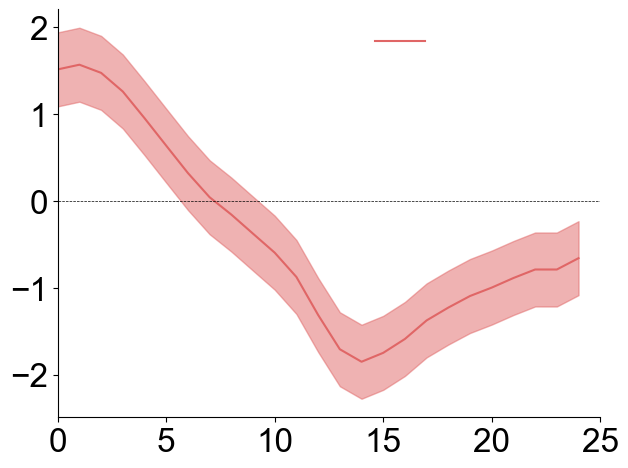

In [22]:
#plot the average flow profile for Krt and Utr
plt.figure(figsize=(7, 5.3)) 
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.rcParams['font.size'] = 24  
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.xlim(0,25)
kvmagavg=[]
uvmagavg=[]
for i,key in enumerate(vmagdict.keys()):
    kvmagavg.append(vmagdict[key][0][:13])
    uvmagavg.append(vmagdict[key][1])
#plt.plot(np.nanmean(kvmagavg,axis=0),color="#83bb03", label="                ")
#plt.fill_between(np.arange(len(np.nanmean(kvmagavg,axis=0))), np.nanmean(kvmagavg,axis=0)-np.std(kvmagavg)/3, np.nanmean(kvmagavg,axis=0)+np.std(kvmagavg)/3, color="#83bb03", alpha=0.5)
plt.plot(np.nanmean(uvmagavg,axis=0),color="#e06666", label="                   ")
plt.fill_between(np.arange(len(np.nanmean(uvmagavg,axis=0))), np.nanmean(uvmagavg,axis=0)-np.std(uvmagavg)/3, np.nanmean(uvmagavg,axis=0)+np.std(uvmagavg)/3, color="#e06666", alpha=0.5)
plt.legend(frameon=False,fontsize=18)
plt.hlines(0,-1,25, color='black', linewidth=0.5, linestyle='--')
if not os.path.exists("H:/PHD_data/Imaging_et_analysis/PaperFigures/Figure5/KrtUtrFlowVel/"):
    os.makedirs("H:/PHD_data/Imaging_et_analysis/PaperFigures/Figure5/KrtUtrFlowVel")
plt.savefig("H:/PHD_data/Imaging_et_analysis/PaperFigures/Figure5/KrtUtrFlowVel/KrtUtrFlowprofile_Thesis.png",dpi=300,transparent=True,bbox_inches='tight')
plt.savefig("H:/PHD_data/Imaging_et_analysis/PaperFigures/Figure5/KrtUtrFlowVel/KrtUtrFlowprofile_Thesis.svg",dpi=300,transparent=True,bbox_inches='tight')
plt.savefig("H:/PHD_data/Imaging_et_analysis/PaperFigures/Figure5/KrtUtrFlowVel/KrtUtrFlowprofile_Thesis.pdf",dpi=300,transparent=True,bbox_inches='tight')
plt.show()

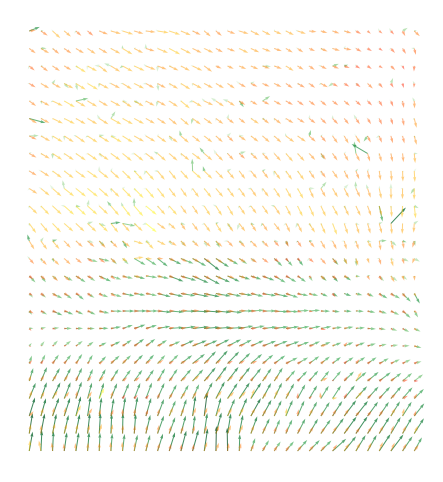

In [23]:
def avgquiver(folder,kjrtfiles, utrfiles, show=True):
    avu=[]
    avu2=[]
    avv=[]
    avv2=[]
    avmag=[]
    avmag2=[]
    avx=[]

    avy=[]
    for numm, (kjrtfile, utrfile) in enumerate(zip(kjrtfiles, utrfiles)):
        x, y, u, v, magnitude, direction = get_krt_data(kjrtfile)
        x2, y2, u2, v2, magnitude2, direction2 = get_krt_data(utrfile)
        avu.append(u)
        avu2.append(u2)
        avv.append(v)
        avv2.append(v2)
        avmag.append(magnitude)
        avmag2.append(magnitude2)
        avx.append(x)
        avy.append(y)
        
    avu=np.nanmean(avu, axis=0)
    avu2=np.nanmean(avu2, axis=0)
    avv=np.nanmean(avv, axis=0)
    avv2=np.nanmean(avv2, axis=0)
    avmag=np.nanmean(avmag, axis=0)
    avmag2=np.nanmean(avmag2, axis=0)
    avx=np.nanmean(avx, axis=0)
    avy=np.nanmean(avy, axis=0)
    return avx, avy, avu,avu2, avv,avv2, avmag,avmag2
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis("off")
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.rcParams['font.size'] = 24
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.gca().set_aspect(1.5, adjustable='box')
plt.gca().spines['left'].set_color('none')

avx, avy, avu, avu2, avv, avv2, avmag, avmag2 = avgquiver(folderkrt2, krtfiles, utrfiles)
np.nanmean(avv,axis=0)
ax.quiver(avx, avy, avu, avv, avmag, cmap="Greens", label="Krt flow",alpha=0.75)
ax.quiver(avx, avy, avu2, avv2, avmag2, cmap="autumn", label="Utr flow",alpha=0.5)
#plt.savefig("H:/PHD_data/Imaging_et_analysis/PaperFigures/Figure5/KrtUtrFlowVel/KrtUtrFlowQuiver.png",dpi=300,transparent=True,bbox_inches='tight')
#plt.savefig("H:/PHD_data/Imaging_et_analysis/PaperFigures/Figure5/KrtUtrFlowVel/KrtUtrFlowQuiver.svg",dpi=300,transparent=True,bbox_inches='tight')
#plt.savefig("H:/PHD_data/Imaging_et_analysis/PaperFigures/Figure5/KrtUtrFlowVel/KrtUtrFlowQuiver.pdf",dpi=300,transparent=True,bbox_inches='tight')
plt.savefig("H:/PHD_data/Imaging_et_analysis/PaperFigures/Figure5/KrtUtrFlowVel/KrtUtrFlowQuiver_Thesisdefense.png",dpi=300,transparent=True,bbox_inches='tight')
plt.savefig("H:/PHD_data/Imaging_et_analysis/PaperFigures/Figure5/KrtUtrFlowVel/KrtUtrFlowQuiver_Thesisdefense.pdf",dpi=300,transparent=True,bbox_inches='tight')

plt.show()
#plot_quiver(folderkrt2,x2,y2,u2,v2,magnitude2,direction2,show=True)

  0%|                                                                                                                                 | 0/299 [00:00<?, ?it/s]

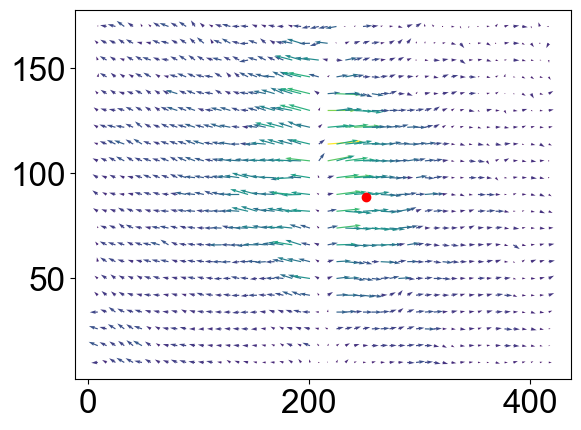

  0%|▍                                                                                                                        | 1/299 [00:00<02:27,  2.03it/s]

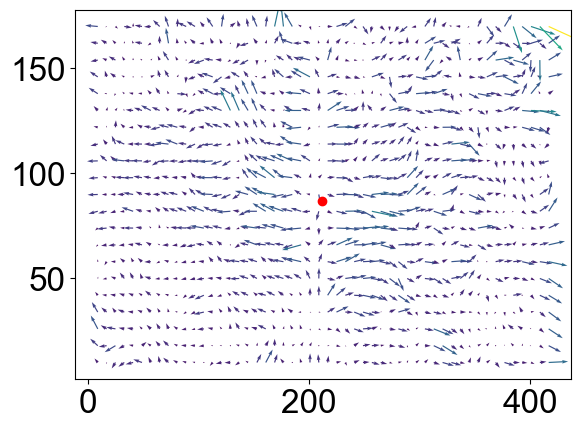

  1%|▊                                                                                                                        | 2/299 [00:00<02:11,  2.26it/s]

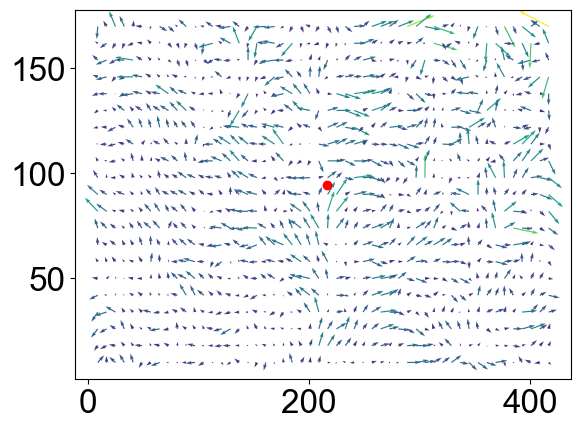

  1%|▊                                                                                                                        | 2/299 [00:01<03:17,  1.50it/s]


In [31]:
#YSL cut hydro dynamic length
folderYSL="H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts/"
PIVfolders= glob(folderYSL+"*/PIV/ASCII/")

testPIV=glob(PIVfolders[4]+"*txt")
for i,file in enumerate(tqdm(testPIV)):
    name=os.path.basename(file)[:-4]
    x,y,u,v,magnitude,direction=get_data(file)
    uniqx=np.unique(x)
    xcenter=uniqx[len(uniqx)//2]
    plot_quiver(testfolder,x,y,u,v,magnitude,direction)
    
    #plot_spatialaverage(folderYSL,x,y,u,v,magnitude,direction,show=True)
    #plt.savefig(folderYSL+f'/{name}_spatialaverage.png',dpi=300,transparent=True,bbox_inches='tight')
    if i>1:
        break


In [17]:
PIVfolders[4]

'H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\\Pos0009\\PIV\\ASCII\\'

Left side of the cut: 10.0
Left side of the cut: 18.0
Left side of the cut: 26.0
Left side of the cut: 34.0
Left side of the cut: 42.0
Left side of the cut: 50.0
Left side of the cut: 58.0
Left side of the cut: 66.0
Left side of the cut: 74.0
Left side of the cut: 82.0
Right side of the cut: 90.0
Right side of the cut: 98.0
Right side of the cut: 106.0
Right side of the cut: 114.0
Right side of the cut: 122.0
Right side of the cut: 130.0
Right side of the cut: 138.0
Right side of the cut: 146.0
Right side of the cut: 154.0
Right side of the cut: 162.0
Right side of the cut: 170.0
length of left side: 10, length of right side: 11


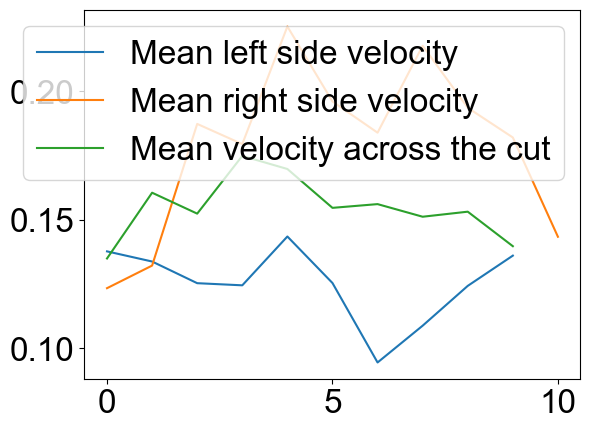

In [27]:
dat1=np.loadtxt(testPIV[0], skiprows=3, delimiter=",")
uniqx=np.unique(dat1[:,1])
uniqxcenter=uniqx[uniqx.shape[0]//2]
meanleftvmah=np.zeros(len([x  for x in uniqx if x < uniqxcenter]))
meanrightvmah=np.zeros(len([x  for x in uniqx if x >= uniqxcenter]))
for i,x in enumerate(uniqx):
    if x <uniqxcenter:
        print(f"Left side of the cut: {x}")
        indices= np.where(dat1[:,1] == x)
        meanleftvmah[i]=np.nanmean(dat1[indices,3])
     
    else:
        print(f"Right side of the cut: {x}")
        indices= np.where(dat1[:,1] == x)
        meanrightvmah[i-len([x  for x in uniqx if x < uniqxcenter])]=np.nanmean(dat1[indices,3])
plt.plot(meanleftvmah, label="Mean left side velocity")
plt.plot(meanrightvmah, label="Mean right side velocity")
plt.plot(np.mean([meanleftvmah, meanrightvmah[1:]], axis=0), label="Mean velocity across the cut")
print(f"length of left side: {len(meanleftvmah)}, length of right side: {len(meanrightvmah)}")
plt.legend()

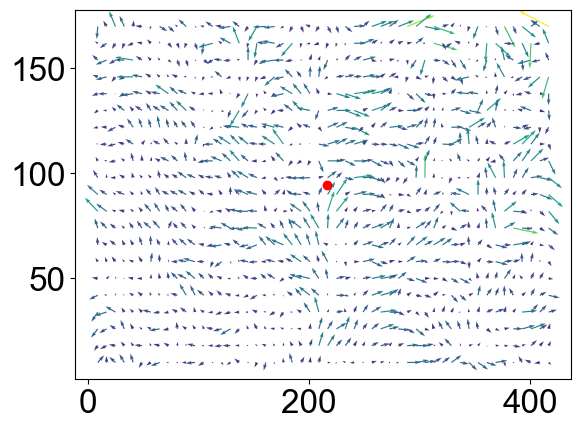

In [20]:
testfile=testPIV[2]
''''dat1=np.loadtxt(testfile, skiprows=3, delimiter=",")

uniqx=np.unique(dat1[:,1])
uniqxcenter=uniqx[uniqx.shape[0]//2]

meanleftvmah=np.zeros(len([x  for x in uniqx if x < uniqxcenter]))
meanrightvmah=np.zeros(len([x  for x in uniqx if x >= uniqxcenter]))
for i,x in enumerate(uniqx):
    if x <uniqxcenter:
        print(f"Left side of the cut: {x}")
        indices= np.where(dat1[:,1] == x)
        meanleftvmah[i]=np.nanmean(dat1[indices,2])
        print(f"Left side of the cut: {x}, Mean velocity: {meanleftvmah[i]}")
    elif x >uniqxcenter:
        print(f"Right side of the cut: {x}")
        indices= np.where(dat1[:,1] == x)
        meanrightvmah[i-len([x  for x in uniqx if x < uniqxcenter])]=np.nanmean(dat1[indices,2])
plt.plot(meanleftvmah, label="Mean left side velocity")
plt.plot(meanrightvmah, label="Mean right side velocity")'''

qx,qy,qu,qv,magn,direc= get_data(testfile)

plot_quiver(testfolder,qx,qy,qu,qv,magn,direc,show=True)

Left side of the cut at 10.0, i is 0 vamag index would be 0, vmag value is nan
Left side of the cut at 18.0, i is 1 vamag index would be 1, vmag value is nan
Left side of the cut at 26.0, i is 2 vamag index would be 2, vmag value is nan
Left side of the cut at 34.0, i is 3 vamag index would be 3, vmag value is nan
Left side of the cut at 42.0, i is 4 vamag index would be 4, vmag value is nan
Left side of the cut at 50.0, i is 5 vamag index would be 5, vmag value is nan
Left side of the cut at 58.0, i is 6 vamag index would be 6, vmag value is nan
Left side of the cut at 66.0, i is 7 vamag index would be 7, vmag value is nan
Left side of the cut at 74.0, i is 8 vamag index would be 8, vmag value is nan
Left side of the cut at 82.0, i is 9 vamag index would be 9, vmag value is nan
Right side of the cut at 90.0,modx is -54.0,  i is 10 vamag index would be -1, vamg value is nan 
Right side of the cut at 98.0,modx is -46.0,  i is 11 vamag index would be 0, vamg value is nan 
Right side of t

C:\Users\snaik\AppData\Local\Temp\ipykernel_19740\4040484125.py:5: RuntimeWarning: Mean of empty slice
  meanleftvmah[i]=np.nanmean(qu[lindices])
C:\Users\snaik\AppData\Local\Temp\ipykernel_19740\4040484125.py:9: RuntimeWarning: Mean of empty slice
  meanrightvmah[i-len([x  for x in uniqx if x >= uniqxcenter])]=np.nanmean(qu[rindices])


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

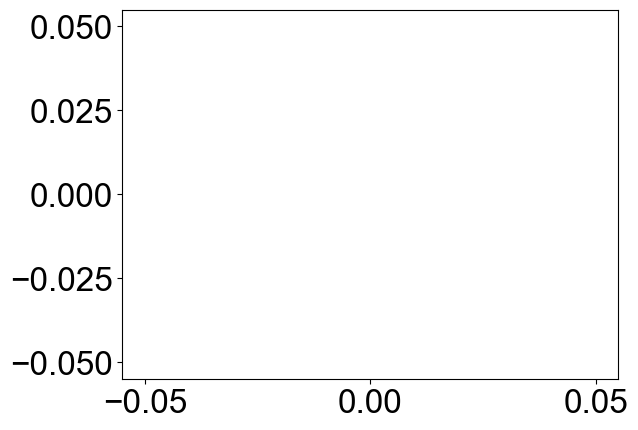

In [22]:
for i, x in enumerate(uniqx):
    if x < uniqxcenter:
        
        lindices = np.where(qx == x)
        meanleftvmah[i]=np.nanmean(qu[lindices])
        print(f"Left side of the cut at {x}, i is {i} vamag index would be {i}, vmag value is {meanleftvmah[i]}")
    elif x >= uniqxcenter:
        rindices = np.where(qx == x)
        meanrightvmah[i-len([x  for x in uniqx if x >= uniqxcenter])]=np.nanmean(qu[rindices])
        print(f"Right side of the cut at {x},modx is {x-144},  i is {i} vamag index would be {i-len([x  for x in uniqx if x >= uniqxcenter])}, vamg value is {meanrightvmah[i-len([x  for x in uniqx if x >= uniqxcenter])]} ")
plt.plot([x  for x in uniqx if x < uniqxcenter],-meanleftvmah[::-1], label="Mean left side velocity")
plt.plot([x-144  for x in uniqx if x >= uniqxcenter],meanrightvmah, label="Mean right side velocity")
plt.plot([x  for x in uniqx if x < uniqxcenter],np.mean([-meanleftvmah[::-1], meanrightvmah], axis=0), label="Mean velocity across the cut")
plt.legend(frameon=False, fontsize=18)

In [17]:

def plot_xaxisaveragecut(folder,testfile,show=True):
    qx,qy,qu,qv,magn,direc= get_data(testfile)
    uniqx=np.unique(qx)
    uniqxcenter=uniqx[uniqx.shape[0]//2]
    meanleftvmah=np.zeros(len([x  for x in uniqx if x < uniqxcenter]))
    meanrightvmah=np.zeros(len([x  for x in uniqx if x >= uniqxcenter]))
    for i, x in enumerate(uniqx):
        if x < uniqxcenter:
            lindices = np.where(qx == x)
            meanleftvmah[i]=np.nanmean(qu[lindices])
        elif x >= uniqxcenter:
            rindices = np.where(qx == x)
            meanrightvmah[i-len([x  for x in uniqx if x < uniqxcenter])]=np.nanmean(qu[rindices])
    plt.figure(figsize=(10, 6))
    plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
    plt.rcParams['font.size'] = 24
    plt.rcParams['savefig.dpi'] = 300
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = 'Arial'
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['top'].set_color('none')
    
    plt.plot([x  for x in uniqx if x < uniqxcenter],-meanleftvmah[::-1], label="left u")
    plt.plot([x-np.max([x for x in uniqx if x<uniqxcenter ])+1  for x in uniqx if x >= uniqxcenter],meanrightvmah, label="Right u")
    plt.plot([x  for x in uniqx if x < uniqxcenter],np.nanmean([-meanleftvmah[::-1],meanrightvmah],axis=0) , label="Mean u in x")
    
    plt.legend(frameon=False, fontsize=18)
    savefolder=folder+"/CutFlowProfile/"
    if not os.path.exists(savefolder):
        os.makedirs(savefolder)
    plt.savefig(savefolder+f'/{os.path.basename(testfile)[:-4]}_spatialaverage.png',dpi=300,transparent=True,bbox_inches='tight')
    plt.savefig(savefolder+f'/{os.path.basename(testfile)[:-4]}_spatialaverage.svg',dpi=300,transparent=True,bbox_inches='tight')
    plt.savefig(savefolder+f'/{os.path.basename(testfile)[:-4]}_spatialaverage.pdf',dpi=300,transparent=True,bbox_inches='tight')   
    if show:
        plt.show()
    else:
        plt.close()

    return [x  for x in uniqx if x < uniqxcenter], np.nanmean([-meanleftvmah[::-1],meanrightvmah],axis=0)
def exponential_fit(x, y):
    # Fit an exponential function to the data
    def model_func(x, a, b):
        return a * np.exp(-b * x)

    # Perform the curve fitting
    params, _ = curve_fit(model_func, x, y,p0=[1,0.1],bounds=([0, 0], [np.inf, 10]),maxfev=2000)
    return params

In [18]:
folder

'H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\\Pos0035\\PIV\\ASCII\\'

Processing folder: H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0004\PIV\ASCII\
Exponential fit parameters for H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0004\PIV\ASCII\: A0.4083876741768101 and decay rate 0.033669952340033914


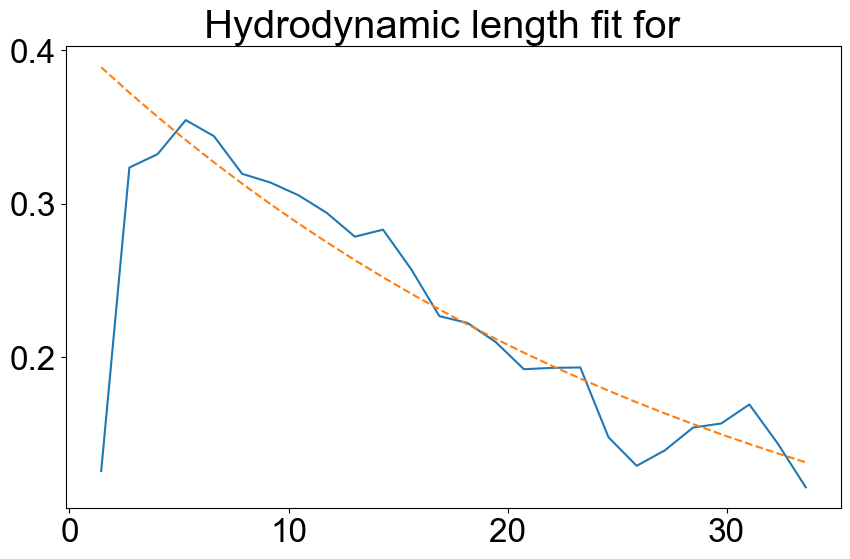

Processing folder: H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0007\PIV\ASCII\
Exponential fit parameters for H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0007\PIV\ASCII\: A0.5613634982172578 and decay rate 0.03772420366558527


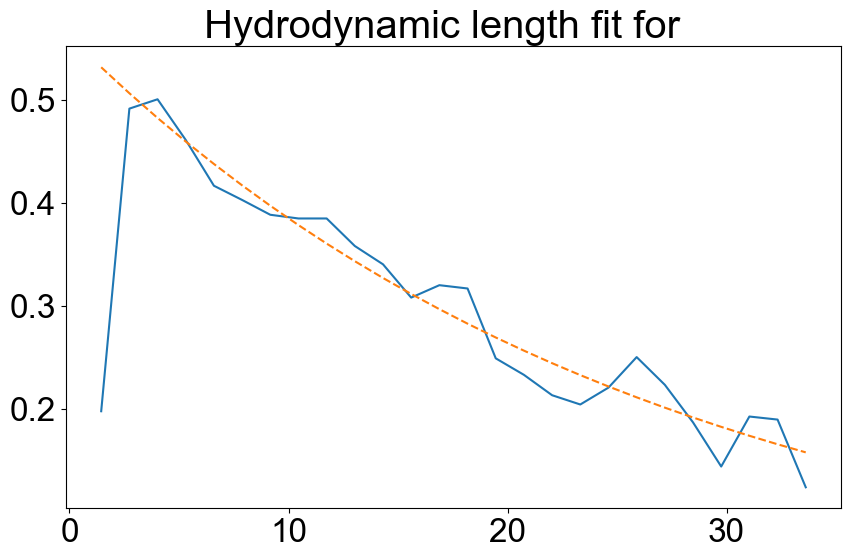

Processing folder: H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0008\PIV\ASCII\
Exponential fit parameters for H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0008\PIV\ASCII\: A0.5621379282042479 and decay rate 0.030463979184938164


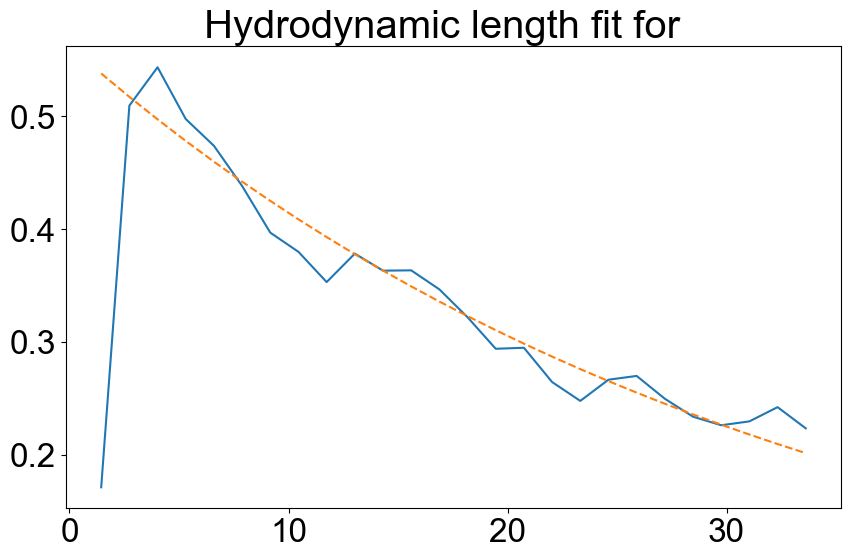

Processing folder: H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0009\PIV\ASCII\
Exponential fit parameters for H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0009\PIV\ASCII\: A1.044848581221774 and decay rate 0.04034528681939715


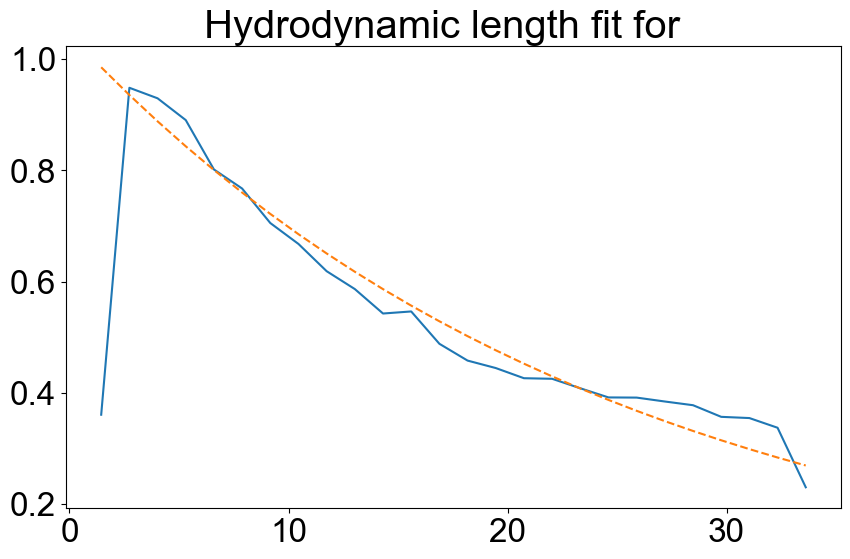

Processing folder: H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0010\PIV\ASCII\
Exponential fit parameters for H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0010\PIV\ASCII\: A0.1069946234188553 and decay rate 0.027107132206034945


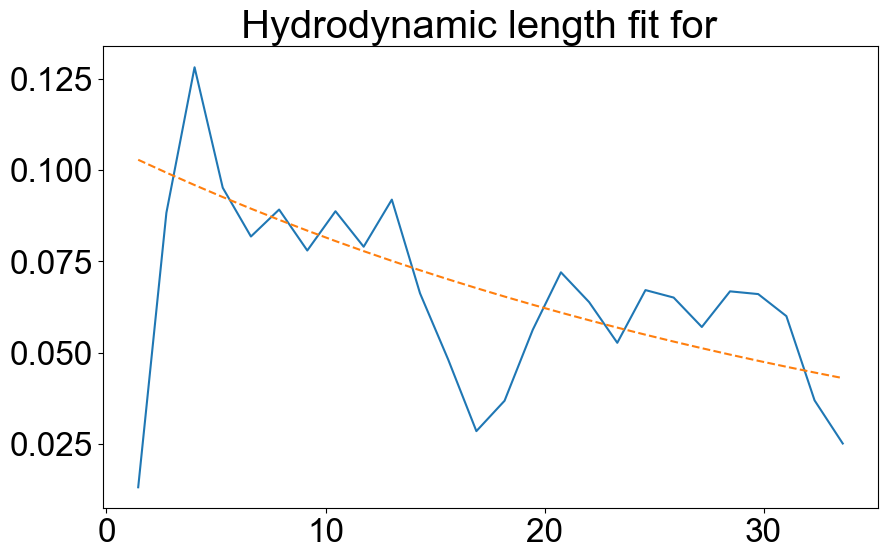

Processing folder: H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0012\PIV\ASCII\
Exponential fit parameters for H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0012\PIV\ASCII\: A0.1674226327523367 and decay rate 0.021119583568006955


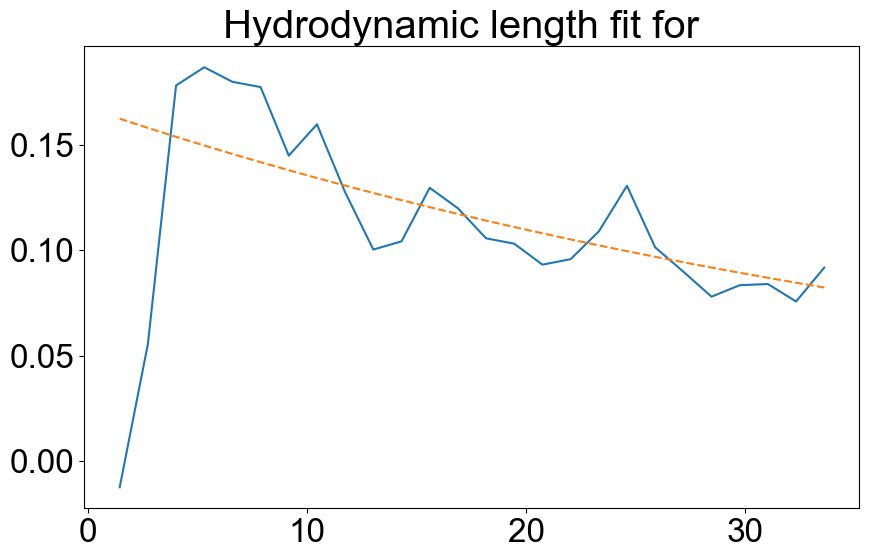

Processing folder: H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0020\PIV\ASCII\
Exponential fit parameters for H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0020\PIV\ASCII\: A0.7082760696350766 and decay rate 0.0320870321719695


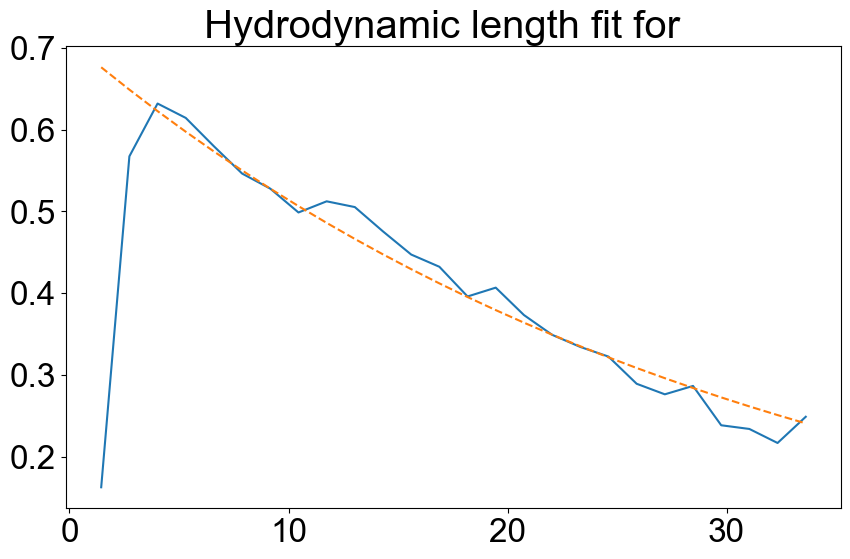

Processing folder: H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0022\PIV\ASCII\
Exponential fit parameters for H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0022\PIV\ASCII\: A0.7037309610906153 and decay rate 0.035813075311835724


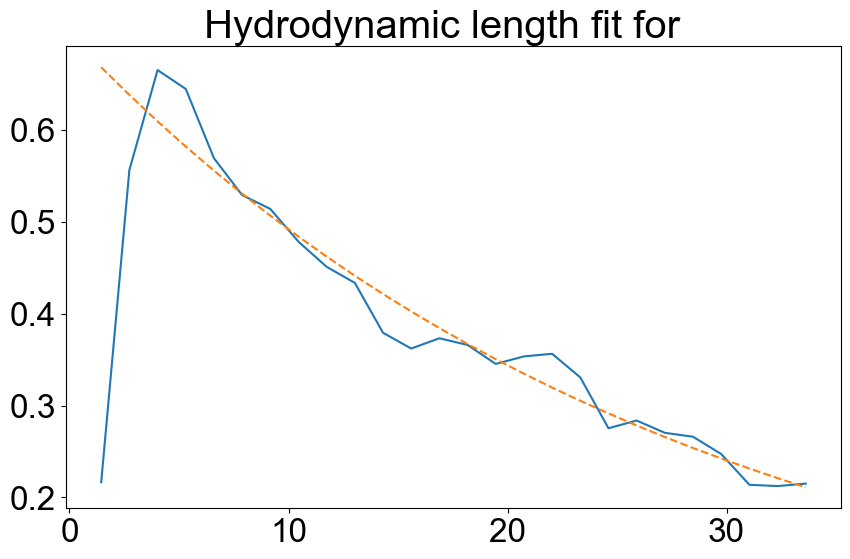

Processing folder: H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0023\PIV\ASCII\
Exponential fit parameters for H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0023\PIV\ASCII\: A0.7337430410794568 and decay rate 0.04781747154883809


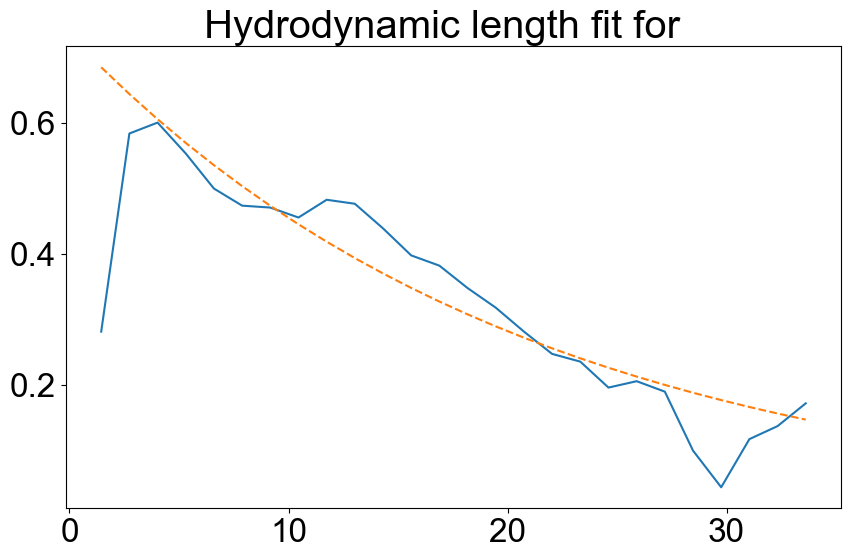

Processing folder: H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0025\PIV\ASCII\
Exponential fit parameters for H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0025\PIV\ASCII\: A0.43037930307304983 and decay rate 0.03854533903926422


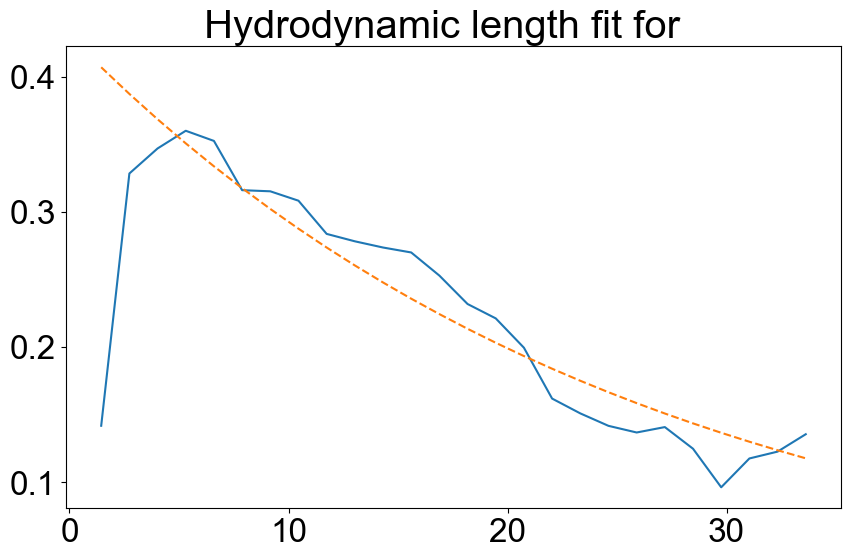

Processing folder: H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0026\PIV\ASCII\
Exponential fit parameters for H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0026\PIV\ASCII\: A0.6592437042024716 and decay rate 0.04037222792921709


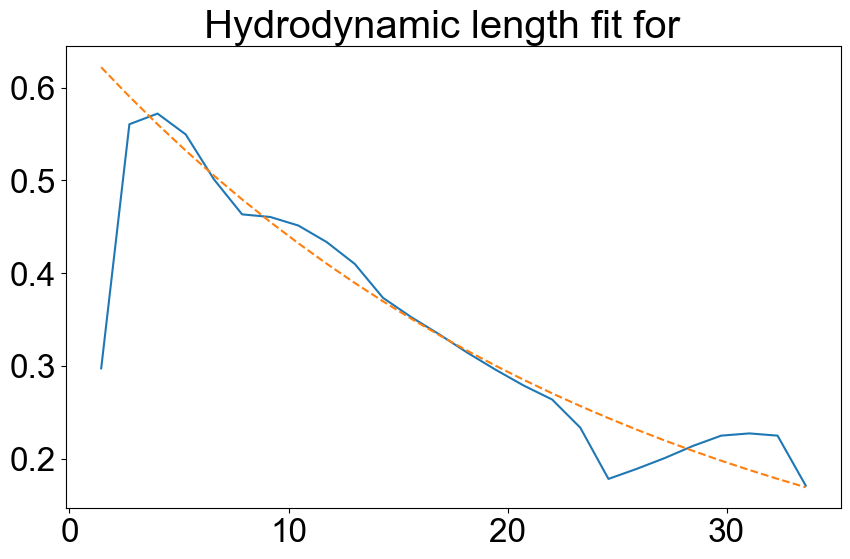

Processing folder: H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0027\PIV\ASCII\
Exponential fit parameters for H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0027\PIV\ASCII\: A0.46490643047094155 and decay rate 0.044103467003416594


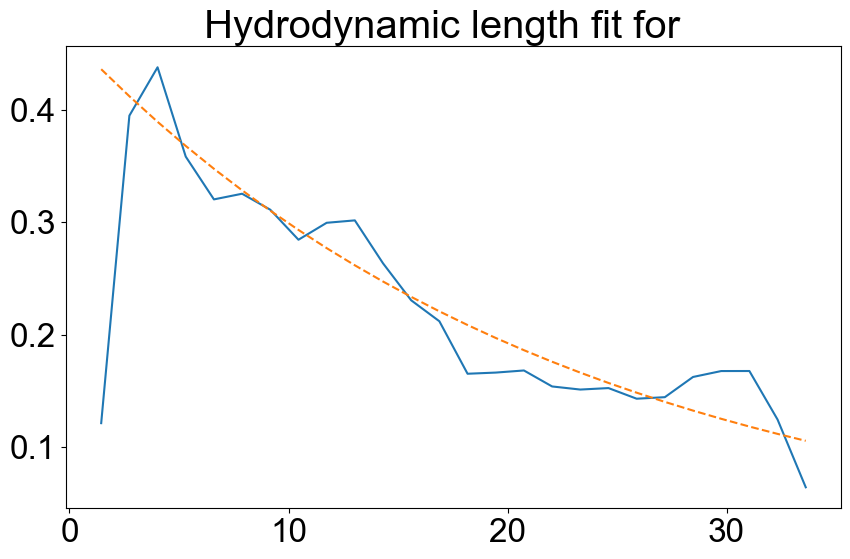

Processing folder: H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0028\PIV\ASCII\
Exponential fit parameters for H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0028\PIV\ASCII\: A1.013614016121213 and decay rate 0.03980198503059229


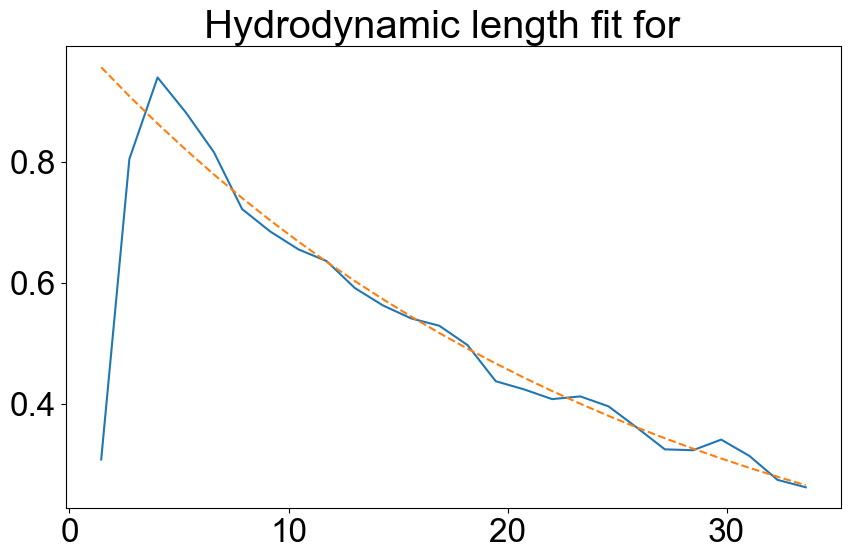

Processing folder: H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0029\PIV\ASCII\
Exponential fit parameters for H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0029\PIV\ASCII\: A0.612685849882732 and decay rate 0.053412115382766266


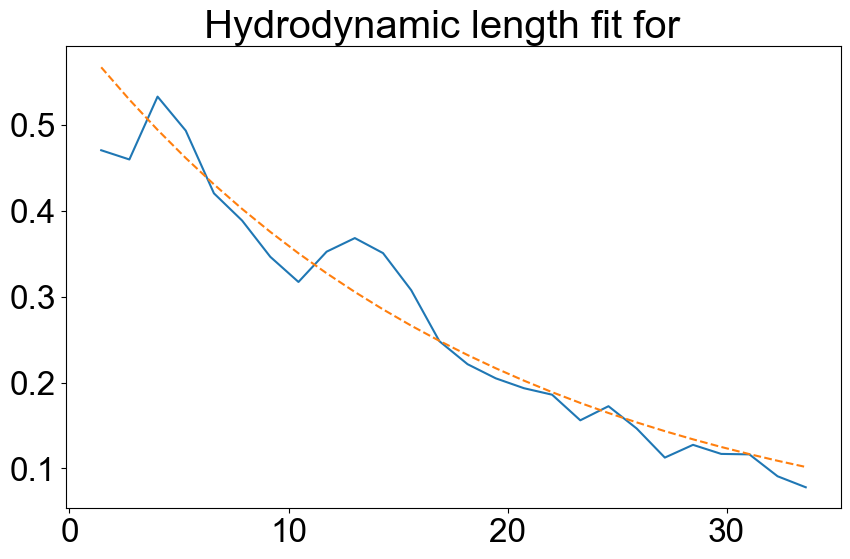

Processing folder: H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0030\PIV\ASCII\
Exponential fit parameters for H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0030\PIV\ASCII\: A0.5720383120226533 and decay rate 0.041318653678377726


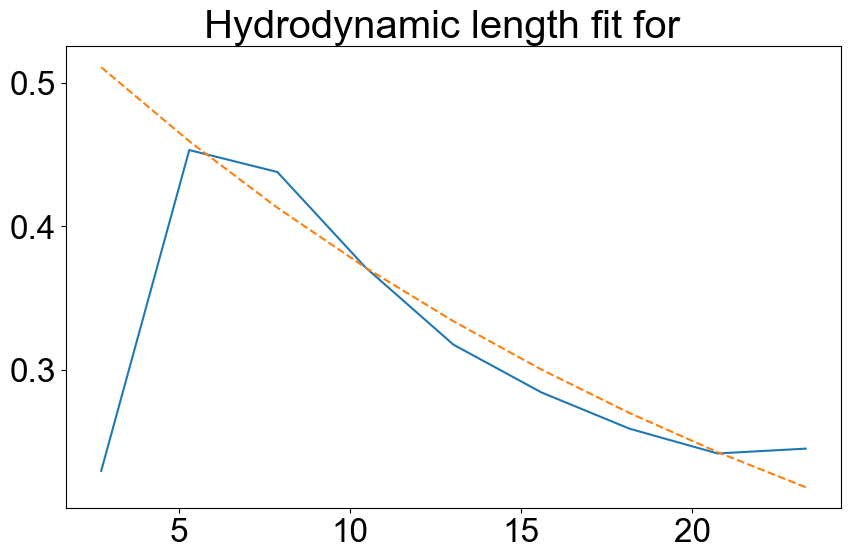

Processing folder: H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0033\PIV\ASCII\
Exponential fit parameters for H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0033\PIV\ASCII\: A0.5654819600119394 and decay rate 0.03860914362614242


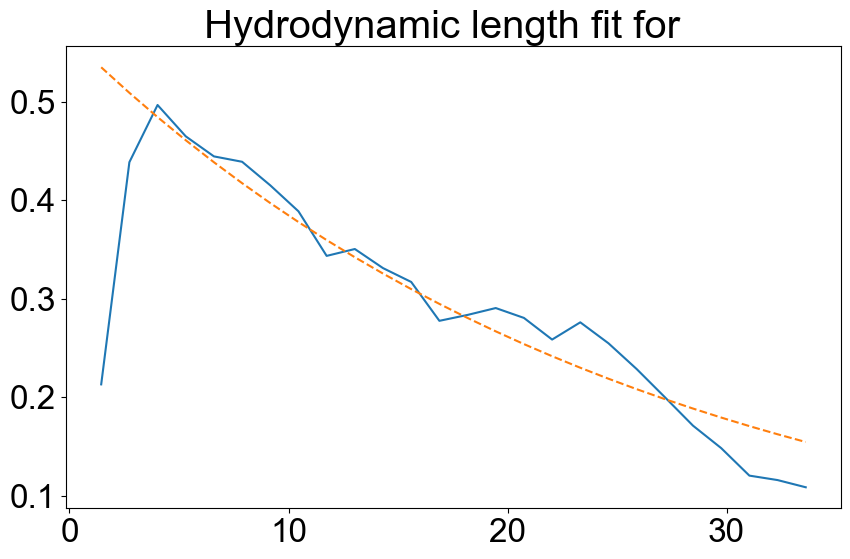

Processing folder: H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0034\PIV\ASCII\
Exponential fit parameters for H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0034\PIV\ASCII\: A0.7180801149372107 and decay rate 0.038177638467364064


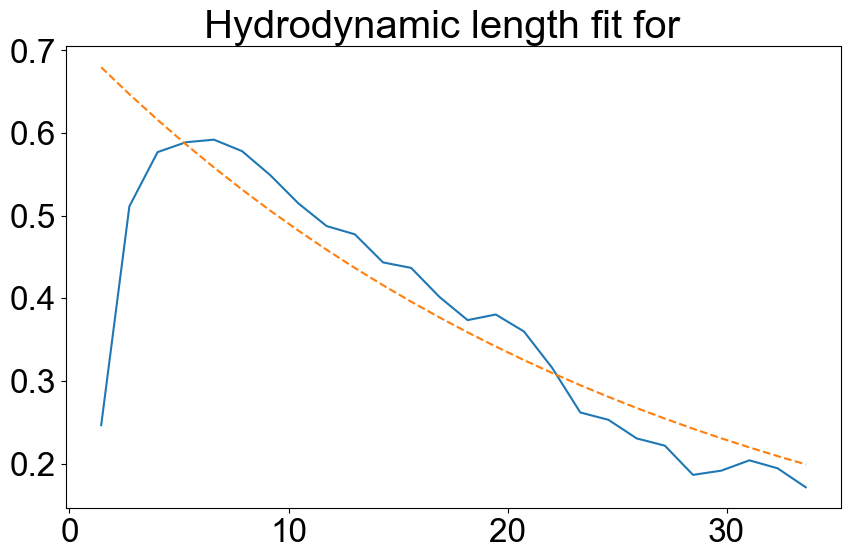

Processing folder: H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0035\PIV\ASCII\
Exponential fit parameters for H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0035\PIV\ASCII\: A0.8379498638642257 and decay rate 0.04386631169651864


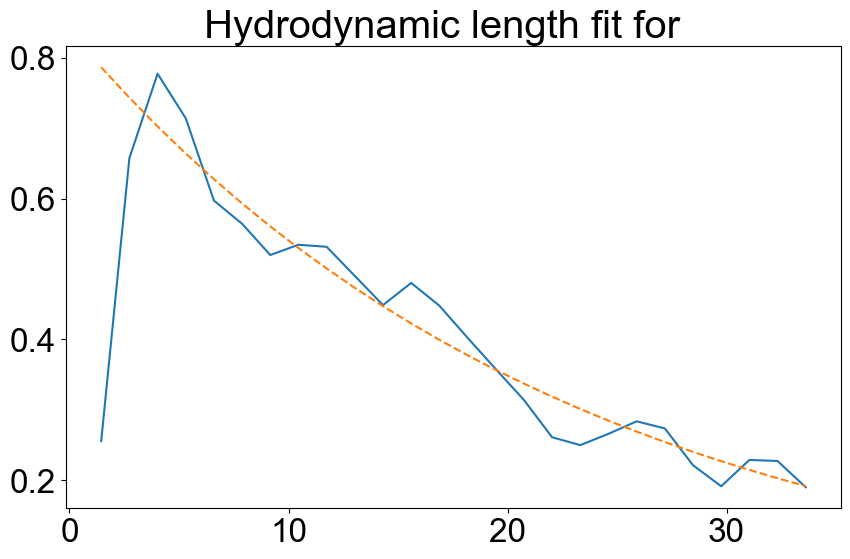

C:\Users\snaik\AppData\Local\Temp\ipykernel_8728\1998493236.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot=plt.boxplot([[1/x for x in hydrodynmllengthC], [1/x for x in hydrodynmllengthYSLMO]],patch_artist=True,labels=["      ", "   "],showfliers=False)


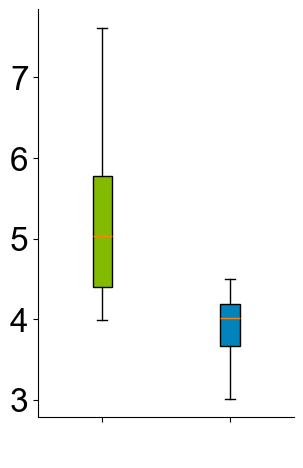

In [19]:
#YSL cut hydro dynamic length
folderYSL="H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts/"
PIVfolders= glob(folderYSL+"*/PIV/ASCII/")
hydrodynmllengthC=[]
hydrodynmllengthYSLMO=[]
#fits for all the cuts
for control,folder in enumerate(PIVfolders):
    PIVfile=glob(folder+"*.txt")[0]
    print(f"Processing folder: {folder}")
    qx, qy, qu, qv, magnitude, direction = get_data(PIVfile)
    qx=qx*0.1608510  # Convert to micrometers
    qy=qy*0.1608510  # Convert to micrometers
    qu=qu*0.1608510/0.25   
    qv=qv*0.1608510/0.25  # Convert to micrometers
    uniqx=np.unique(qx)
    uniqxcenter=uniqx[uniqx.shape[0]//2]
    meanleftvmah=np.zeros(len([x  for x in uniqx if x < uniqxcenter]))
    meanrightvmah=np.zeros(len([x  for x in uniqx if x >= uniqxcenter]))
    for i, x in enumerate(uniqx):
        if x < uniqxcenter:
            lindices = np.where(qx == x)
            meanleftvmah[i]=np.nanmean(qu[lindices])
        elif x >= uniqxcenter:
            rindices = np.where(qx == x)
            meanrightvmah[i-len([x  for x in uniqx if x < uniqxcenter])]=np.nanmean(qu[rindices])
    meanUdata = np.nanmean([-meanleftvmah[::-1], meanrightvmah], axis=0)
    xdata = [x for x in uniqx if x < uniqxcenter]
    params = exponential_fit(xdata[1:], meanUdata[1:])
    print(f"Exponential fit parameters for {folder}: A{params[0]} and decay rate {params[1]}")
    plt.figure(figsize=(10, 6))
    plt.title(f"Hydrodynamic length fit for {os.path.basename(folder)} ")
    plt.plot(xdata, meanUdata, label=f"{os.path.basename(folder)}: {params[1]/0.1608510:.2f} um")
    plt.plot(xdata, params[0] * np.exp(-params[1] * np.array(xdata)), linestyle='--', label=f"Fit: {params[1]/0.1608510:.2f} um")
    plt.show()
    if control <6:
        hydrodynmllengthC.append(params[1]/0.1608510)
    else:
        hydrodynmllengthYSLMO.append(params[1]/0.1608510)
plt.figure(figsize=(3.3, 5.3))
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.rcParams['font.size'] = 24
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.yticks(np.arange(0, 0.5, 0.01), minor=True)
boxplot=plt.boxplot([[1/x for x in hydrodynmllengthC], [1/x for x in hydrodynmllengthYSLMO]],patch_artist=True,labels=["      ", "   "],showfliers=False)
for iu,bplot in enumerate(boxplot['boxes']):
    bplot.set_facecolor("#83bb03" if iu==0 else "#0383bb")
#plt.legend(frameon=False, fontsize=18)
plt.savefig("H:/PHD_data/Imaging_et_analysis/PaperFigures/Figure5/YSLhydrodynamiclength/YSLhydrodynamiclength.png",dpi=300,transparent=True,bbox_inches='tight')
plt.savefig("H:/PHD_data/Imaging_et_analysis/PaperFigures/Figure5/YSLhydrodynamiclength/YSLhydrodynamiclength.svg",dpi=300,transparent=True,bbox_inches='tight')
plt.savefig("H:/PHD_data/Imaging_et_analysis/PaperFigures/Figure5/YSLhydrodynamiclength/YSLhydrodynamiclength.pdf",dpi=300,transparent=True,bbox_inches='tight')
plt.show()

Processing folder: H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0004\PIV\ASCII\
Max velocity for H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0004\PIV\ASCII\: 0.3545659952204835
Processing folder: H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0007\PIV\ASCII\
Max velocity for H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0007\PIV\ASCII\: 0.500483364051735
Processing folder: H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0008\PIV\ASCII\
Max velocity for H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0008\PIV\ASCII\: 0.5433980050015301
Processing folder: H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0009\PIV\ASCII\
Max velocity for H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos0009\PIV\ASCII\: 0.9486902388254105
Processing folder: H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts\Pos

C:\Users\snaik\AppData\Local\Temp\ipykernel_8728\3658697207.py:45: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot=plt.boxplot([maxvel,maxvelMO[:-1]],patch_artist=True,labels=["      ", "   "],showfliers=False)
C:\Users\snaik\AppData\Local\Temp\ipykernel_8728\3658697207.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False, fontsize=18)


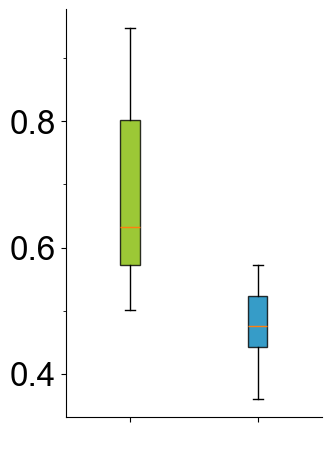

In [20]:
#YSL cut hydro dynamic length
folderYSL="H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts/"
PIVfolders= glob(folderYSL+"*/PIV/ASCII/")
maxvel=[]
maxvelMO=[]
#fits for all the cuts
for control,folder in enumerate(PIVfolders):
    PIVfile=glob(folder+"*.txt")[0]
    print(f"Processing folder: {folder}")
    qx, qy, qu, qv, magnitude, direction = get_data(PIVfile)
    qx=qx*0.1608510  # Convert to micrometers
    qy=qy*0.1608510  # Convert to micrometers
    qu=qu*0.1608510/0.25   
    qv=qv*0.1608510/0.25  # Convert to micrometers
    uniqx=np.unique(qx)
    uniqxcenter=uniqx[uniqx.shape[0]//2]
    meanleftvmah=np.zeros(len([x  for x in uniqx if x < uniqxcenter]))
    meanrightvmah=np.zeros(len([x  for x in uniqx if x >= uniqxcenter]))
    for i, x in enumerate(uniqx):
        if i ==5 or i == 6 or i ==12:
            continue
        if x < uniqxcenter:
            lindices = np.where(qx == x)
            meanleftvmah[i]=np.nanmean(qu[lindices])
        elif x >= uniqxcenter:
            rindices = np.where(qx == x)
            meanrightvmah[i-len([x  for x in uniqx if x < uniqxcenter])]=np.nanmean(qu[rindices])
    meanUdata = np.nanmean([-meanleftvmah[::-1], meanrightvmah], axis=0)
    if control < 6:
        maxvel.append(np.nanmax(meanUdata))
    else:
        maxvelMO.append(np.nanmax(meanUdata))
    print(f"Max velocity for {folder}: {np.nanmax(meanUdata)}")
maxvel=[0.500483364051735,0.5433980050015301,0.9486902388254105,0.940022907532846,0.6318017925070312,0.6651139860530078, 0.600267418923502]
maxvelMO=[0.3600669630173342,0.5719578886987746, 0.4378707478629063,0.532934218345794,0.453244164077901, 0.4964564308333335,0.5919035480041848]
fig,ax = plt.subplots(figsize=(3.3, 5.3))
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 24
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.yticks(np.arange(0, 1, 0.1), minor=True)
boxplot=plt.boxplot([maxvel,maxvelMO[:-1]],patch_artist=True,labels=["      ", "   "],showfliers=False)
for iu,bplot in enumerate(boxplot['boxes']):
    bplot.set_facecolor("#83bb03" if iu==0 else "#0383bb")
    bplot.set_alpha(0.8)
plt.legend(frameon=False, fontsize=18)
plt.savefig("H:/PHD_data/Imaging_et_analysis/PaperFigures/Figure5/YSLhydrodynamiclength/YSLhydrodynamiclengthmaxvel.png",dpi=300,transparent=True,bbox_inches='tight')
plt.savefig("H:/PHD_data/Imaging_et_analysis/PaperFigures/Figure5/YSLhydrodynamiclength/YSLhydrodynamiclengthmaxvel.svg",dpi=300,transparent=True,bbox_inches='tight')
plt.savefig("H:/PHD_data/Imaging_et_analysis/PaperFigures/Figure5/YSLhydrodynamiclength/YSLhydrodynamiclengthmaxvel.pdf",dpi=300,transparent=True,bbox_inches='tight')
plt.show()

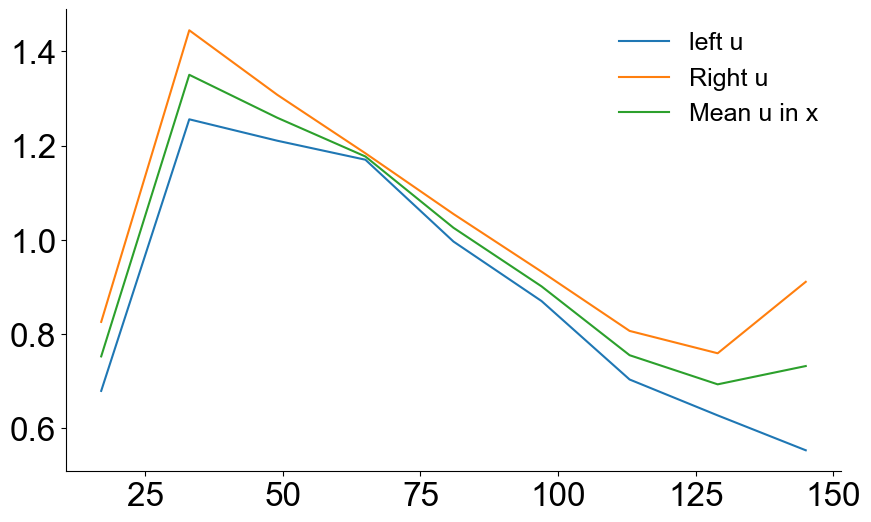

Exponential fit parameters: a=1.714222346935699, b=0.0065253888647512515


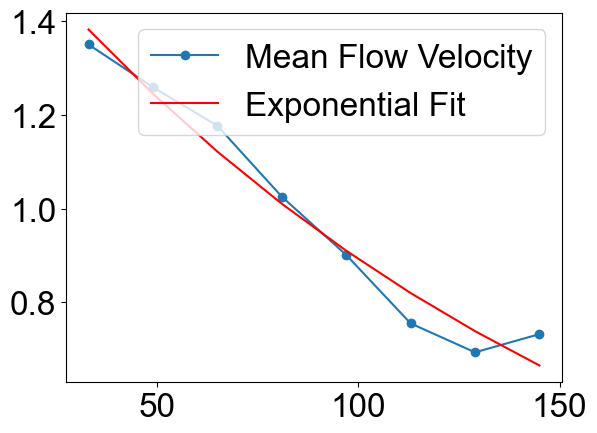

In [48]:
x,meanUf=plot_xaxisaveragecut(folderYSL,testPIV[0],show=True)

a,b=exponential_fit(x[1:],meanUf[1:])
print(f"Exponential fit parameters: a={a}, b={b}")
# Generate fitted values
fitted_y = a * np.exp(-b * np.array(x[1:]))
plt.plot(x[1:], meanUf[1:], label='Mean Flow Velocity', marker='o')
plt.plot(x[1:], fitted_y, label='Exponential Fit', color='red')
plt.legend()
plt.show()


In [22]:
curve_fit(exp_decay,x,meanUf)

C:\Users\snaik\AppData\Local\Temp\ipykernel_13364\2940115588.py:4: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)


(array([1.2422579 , 0.00327271]),
 array([[3.49364872e-02, 3.01374748e-04],
        [3.01374748e-04, 3.46610111e-06]]))

In [ ]:
#fit the exponential decay to the mean velocity profile
from scipy.optimize import curve_fit
import warnings

def exp_decay(x, a, b):
    """
    Exponential decay function with overflow protection
    """
    # Prevent overflow by limiting the exponent
    exponent = -b * x
    # Clip exponent to prevent overflow (exp(700) is near the limit for float64)
    exponent = np.clip(exponent, -700, 700)
    return a * np.exp(exponent)

# Check if variables exist and are valid
if 'x' in locals() and 'meanUf' in locals():
    try:
        # Clean the data - remove NaN and infinite values
        x_array = np.array(x)
        meanUf_array = np.array(meanUf)
        
        # Create mask for valid data points
        valid_mask = np.isfinite(x_array) & np.isfinite(meanUf_array)
        x_clean = x_array[valid_mask]
        meanUf_clean = meanUf_array[valid_mask]
        
        if len(x_clean) > 2:  # Need at least 3 points for fitting
            # Use bounds to prevent unrealistic parameter values
            # bounds: ([a_min, b_min], [a_max, b_max])
            bounds = ([-np.inf, 0], [np.inf, 10])  # b should be positive for decay
            
            # Skip first point if it might be problematic
            x_fit = x_clean[1:] if len(x_clean) > 3 else x_clean
            y_fit = meanUf_clean[1:] if len(x_clean) > 3 else meanUf_clean
            
            # Suppress warnings temporarily
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", RuntimeWarning)
                
                popt, pcov = curve_fit(exp_decay, x_fit, y_fit, 
                                     bounds=bounds,
                                     p0=[1.0, 0.1],  # Initial guess
                                     maxfev=1000)
            
            fitted_curve = exp_decay(x_fit, *popt)
            
            plt.figure(figsize=(10, 6))
            plt.plot(x_clean, meanUf_clean, label='Mean Velocity Profile', color='blue', linewidth=2)
            plt.plot(x_fit, fitted_curve, label=f'Fitted Exponential Decay\na={popt[0]:.3f}, b={popt[1]:.3f}', 
                    color='red', linestyle='--', linewidth=2)
            plt.xlabel('X Position')
            plt.ylabel('Mean Velocity')
            plt.title('Exponential Decay Fit to Mean Velocity Profile')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
            
            print(f"Fit parameters: a = {popt[0]:.4f}, b = {popt[1]:.4f}")
            print(f"Standard errors: σ_a = {np.sqrt(pcov[0,0]):.4f}, σ_b = {np.sqrt(pcov[1,1]):.4f}")
        else:
            print("Error: Not enough valid data points for fitting")
            
    except Exception as e:
        print(f"Error in exponential fitting: {e}")
        print("Possible issues:")
        print("- Data contains too many NaN or infinite values")
        print("- Data range is too large causing numerical overflow")
        print("- Initial guess parameters are inappropriate")
else:
    print("Error: Variables 'x' and 'meanUf' are not defined.")
    print("Please run the previous cell (plot_xaxisaveragecut) first to generate these variables.")

C:\Users\snaik\AppData\Local\Temp\ipykernel_13364\2940115588.py:5: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(exp_decay, x[1:], meanUf[1:])


TypeError: can't multiply sequence by non-int of type 'numpy.float64'

In [ ]:
# Example usage of robust exponential fitting for YSL cut analysis
# This replaces the previous problematic fitting code

# Check if we have the necessary variables from previous analysis
if 'testfile' in locals():
    try:
        # Use the robust fitting function we defined earlier
        print(f"Analyzing file: {os.path.basename(testfile)}")
        
        # Get data from the current test file
        qx, qy, qu, qv, magn, direc = get_data(testfile)
        uniqx = np.unique(qx)
        uniqxcenter = uniqx[uniqx.shape[0]//2]
        
        # Calculate velocity profiles
        meanleftvmah = np.zeros(len([x for x in uniqx if x < uniqxcenter]))
        meanrightvmah = np.zeros(len([x for x in uniqx if x >= uniqxcenter]))
        
        for i, x in enumerate(uniqx):
            if x < uniqxcenter:
                lindices = np.where(qx == x)
                meanleftvmah[i] = np.nanmean(qu[lindices])
            elif x >= uniqxcenter:
                rindices = np.where(qx == x)
                meanrightvmah[i-len([x for x in uniqx if x < uniqxcenter])] = np.nanmean(qu[rindices])
        
        # Prepare data for fitting
        xdata = np.array([int(x) for x in uniqx if x < uniqxcenter])
        
        # Ensure arrays have the same length before averaging
        left_reversed = -meanleftvmah[::-1]
        min_length = min(len(left_reversed), len(meanrightvmah))
        left_trimmed = left_reversed[:min_length]
        right_trimmed = meanrightvmah[:min_length]
        ydata = np.nanmean([left_trimmed, right_trimmed], axis=0)
        
        # Only fit if we have valid data
        if len(xdata) >= min_length and min_length >= 3:
            xdata_trimmed = xdata[:min_length]
            
            # Use the robust fitting function
            popt, pcov, success = robust_exp_fit(xdata_trimmed, ydata, 
                                               plot=True, 
                                               title=f'Hydrodynamic Length Analysis - {os.path.basename(testfile)}')
            
            if success:
                print(f"Hydrodynamic length scale (1/b): {1/popt[1]:.2f} units")
            else:
                print("Exponential fitting failed for this dataset")
        else:
            print(f"Insufficient data points: {min_length} (need at least 3)")
            
    except Exception as e:
        print(f"Error in analysis: {e}")
else:
    print("Variable 'testfile' not found. Please run the YSL cut analysis section first.")

def measure_hydrodynamic_length(folder, testfile, show=True):
    """
    Improved hydrodynamic length measurement function
    """
    try:
        qx, qy, qu, qv, magn, direc = get_data(testfile)
        uniqx = np.unique(qx)
        uniqxcenter = uniqx[uniqx.shape[0]//2]
        
        meanleftvmah = np.zeros(len([x for x in uniqx if x < uniqxcenter]))
        meanrightvmah = np.zeros(len([x for x in uniqx if x >= uniqxcenter]))
        
        for i, x in enumerate(uniqx):
            if x < uniqxcenter:
                lindices = np.where(qx == x)
                meanleftvmah[i] = np.nanmean(qu[lindices])
            elif x >= uniqxcenter:
                rindices = np.where(qx == x)
                meanrightvmah[i-len([x for x in uniqx if x < uniqxcenter])] = np.nanmean(qu[rindices])
        
        # Prepare data for fitting
        xdata = np.array([int(x) for x in uniqx if x < uniqxcenter])
        left_reversed = -meanleftvmah[::-1]
        min_length = min(len(left_reversed), len(meanrightvmah))
        
        if min_length >= 3:
            left_trimmed = left_reversed[:min_length]
            right_trimmed = meanrightvmah[:min_length]
            ydata = np.nanmean([left_trimmed, right_trimmed], axis=0)
            xdata_trimmed = xdata[:min_length]
            
            # Use robust fitting
            popt, pcov, success = robust_exp_fit(xdata_trimmed, ydata, 
                                               plot=show,
                                               title=f'Hydrodynamic Length - {os.path.basename(testfile)}')
            
            if success:
                hydro_length = 1/popt[1]
                return hydro_length, popt, pcov
            
        return None, None, None
        
    except Exception as e:
        print(f"Error measuring hydrodynamic length: {e}")
        return None, None, None

In [ ]:
#YSL cut hydro dynamic length
folderYSL="H:/PHD_data/Imaging_et_analysis/NikSD/2025/05_Mai/20052025_YSLCuts/"
PIVfolders= glob(folderYSL+"*/PIV/ASCII/")
meanvelC=[]
meanvelM=[]
for j,folder in enumerate(tqdm(PIVfolders)):
    testPIV=glob(folder+"*txt")
    print(f"Processing folder: {folder}, with {len(testPIV)} files")
    control = j < 15  # Fix: properly set control variable for each iteration
    for i,file in enumerate(testPIV):
        meanu=plot_xaxisaveragecut(folder,file,show=False)
        if i==0 and control:
            meanvelC.append(meanu)
        elif i==0 and not control:
            meanvelM.append(meanu)
        if i>10:
            break